# CIS5026 WRIT1: Airbnb Data Analysis
*ST20166622*

To run this notebook with the data, download the dataset from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data/code) and adjust the first cell to enter the file location of the dataset.

## 1 The Business Analytical Question

In this notebook, the AirBnb summary data for New York is explored, transformed and analysed in order to answer the question, "what factors influence whether or not a listing is reviewed?".

The dataset explored in this notebook contains 20% listings that have never been reviewed. This implies that they have never been booked, but seems too high a proportion to be entirely explained by new listings. According to Airbnb's [website](https://www.airbnb.co.uk/help/article/39/what-factors-determine-how-my-listing-appears-in-search-results), when listings are sorted by the Airbnb search algorithm the number (as well as rating) of reviews is taken into account (Airbnb, 2020). Indeed, reviews are core to Airbnb's business strategy, as they mitigate the "perceived risk" of inviting complete strangers to stay in one another's homes (Reinhold and Dolnicar, 2018). As a result, the listings that have no reviews are less likely to be booked than those that do have reviews. If these are only the newest listings on the site then this is unlikely to be a problem, but if a relationship can be found between the presence of reviews and the other features in the dataset, this would imply that there is more to a listing's lack of bookings than its time on the market.

Of all of the features in the provided dataset, number of reviews is one of the strongest measures of "success" for a given listing. A host can supply any price they choose, but unless the listing is booked and subsequently reviewed, there is no way to know from this dataset whether or not guests are prepared to pay that price.

Because the listings without reviews were less likely to be booked, it seemed valuable to Airbnb to have a model that could identify these listings early, to prevent the hosts from finding themselves in a cycle of not having reviews making them less likely to get bookings.  The caveat for this model was that it must be interpretable, because of Jhaver *et al.*'s findings that hosts suffer "algorithmic anxiety" when their listings are inexplicably shifted down the search rankings by Airbnb's models (2018). 

Therefore the goal of this investigation is to develop a model that would 

1. identify listings that would potentially never be booked; and
2. be interpretable, so that predictions could be expressed in terms of the features of the dataset.

These two qualities would make the model beneficial to:

- Airbnb executives, who would be able to use it to boost bookings of listings and increase revenue
- to hosts, who could be sent messages when their listing settings make them less likely to be booked, to support them in improving their visibility.

### About the dataset

The dataset is available on [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data/code), where more than 500 notebooks have been submitted containing attempts to use the dataset for analysis, although many of these notebooks have been cloned from a smaller number. Of these notebooks, very few aim to predict the number of reviews or train classification models using the dataset. 

There are two suggested tasks on Kaggle: data analytics using Airbnb data, and predict NYC Airbnb rental prices (Kaggle, 2019).

The dataset comprises summary information about Airbnb listings in New York City as of August 2019.


## 2.1 Exploratory Data Analysis (EDA)

First, the required libraries and data are imported. Adjust the first cell (below) to include the path to the dataset on your machine.

In [1]:
path_to_dataset = 'data/AB_NYC_2019.csv'

In [2]:
# import libraries

import math, csv

from typing import List, Tuple, Dict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, f1_score, classification_report, plot_confusion_matrix, make_scorer

from xgboost import XGBClassifier, plot_importance
import xgboost as xgb
import shap


In [3]:
# load data

airbnb = pd.read_csv(path_to_dataset)

airbnb.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [4]:
num_listings = len(airbnb)
num_listings_without_reviews = len(airbnb[airbnb['number_of_reviews']==0])
num_hosts = len(airbnb['host_id'].unique())
percent_no_reviews = round(num_listings_without_reviews/num_listings*100)

print(f'The data contains information about {num_listings} AirBnB listings from {num_hosts} hosts.',
      f'\nOf these listings, {num_listings_without_reviews} ({percent_no_reviews}%) do not have reviews.')

The data contains information about 48895 AirBnB listings from 37457 hosts. 
Of these listings, 10052 (21%) do not have reviews.


### 2.1.1 Missing values

In [5]:
# check for missing values

airbnb.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Some of these columns are irrelevant to the number of reviews being posted. For example, there's no mechanism by which id, host_name, and host_id could impact the number of reviews. The IDs are identifiers used to track the listings in other data sets (for example, AirBnb likely has data sets of reviews and host details). 

There may be information within the 'name' column that could influence the presence of reviews - for example, the name may list amenities such as a hot tub or garden that would make the listing more likely to be booked and then reviewed. However, this is beyond the scope of this project, so the name column will be removed from the dataset.

Therefore we can safely drop the columns `id`, `name`, `host_id`, and `host_name`, which will in turn address the missing values in `name` and `host_name`.

In [6]:
airbnb = airbnb.drop(['id', 'name', 'host_id', 'host_name'], axis = 1)
airbnb.isna().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Let's investigate these missing values for `last review` and `reviews_per_month`

In [7]:
airbnb[airbnb['last_review'].isna()]['number_of_reviews'].value_counts()

0    10052
Name: number_of_reviews, dtype: int64

In [8]:
airbnb[airbnb['reviews_per_month'].isna()]['number_of_reviews'].value_counts()

0    10052
Name: number_of_reviews, dtype: int64

In [9]:
len(airbnb[airbnb['number_of_reviews']==0])

10052

The missing values correspond to rows where there are no reviews. In these cases there is no date of last review because there have been no reviews, and `reviews_per_month` cannot be calculated.

Therefore we can fill the missing values with 0. It won't make a difference, however, as `reviews_per_month` and `last_review` are so strongly correlated with `number of reviews` that we will not be using them as features in the model.

In [10]:
airbnb.fillna(0, inplace = True)
airbnb.isna().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [11]:
airbnb.drop(columns = ['last_review', 'reviews_per_month'], inplace = True)
airbnb.head()

neighbourhood_group neighbourhood  latitude  longitude        room_type  \
0            Brooklyn    Kensington  40.64749  -73.97237     Private room   
1           Manhattan       Midtown  40.75362  -73.98377  Entire home/apt   
2           Manhattan        Harlem  40.80902  -73.94190     Private room   
3            Brooklyn  Clinton Hill  40.68514  -73.95976  Entire home/apt   
4           Manhattan   East Harlem  40.79851  -73.94399  Entire home/apt   

   price  minimum_nights  number_of_reviews  calculated_host_listings_count  \
0    149               1                  9                               6   
1    225               1                 45                               2   
2    150               3                  0                               1   
3     89               1                270                               1   
4     80              10                  9                               1   

   availability_365  
0               365  
1               355  
2               365  
3               194  
4                 0

In [12]:
airbnb.dtypes

neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

Most of the features are numeric, with some continuous variables such as `latitude`, `longitude`, and `reviews_per_month`, and some integer variables such as `minimum_nights`, `price`, and `calculated_host_listing_count`. 

There are also a number of string variables, such as room type, which will need to be encoded as categorical variables if used.

### 2.1.2 Removal of outliers that are errors

The data is checked for obvious errors, for example:

- price less than or equal to $0
- availability (measured out of 365) greater than 365 or less than 0


In [13]:
airbnb[airbnb['price']<=0]

neighbourhood_group       neighbourhood  latitude  longitude  \
23161            Brooklyn  Bedford-Stuyvesant  40.69023  -73.95428   
25433               Bronx     East Morrisania  40.83296  -73.88668   
25634            Brooklyn            Bushwick  40.69467  -73.92433   
25753            Brooklyn          Greenpoint  40.72462  -73.94072   
25778            Brooklyn        Williamsburg  40.70838  -73.94645   
25794            Brooklyn  Bedford-Stuyvesant  40.68173  -73.91342   
25795            Brooklyn  Bedford-Stuyvesant  40.68279  -73.91170   
25796            Brooklyn  Bedford-Stuyvesant  40.68258  -73.91284   
26259           Manhattan         Murray Hill  40.75091  -73.97597   
26841            Brooklyn            Bushwick  40.69211  -73.90670   
26866            Brooklyn            Bushwick  40.69166  -73.90928   

             room_type  price  minimum_nights  number_of_reviews  \
23161     Private room      0               4                  1   
25433     Private room      0               2                 55   
25634     Private room      0               2                 16   
25753     Private room      0               2                 12   
25778  Entire home/apt      0               5                  3   
25794     Private room      0               1                 93   
25795     Private room      0               1                 95   
25796     Private room      0               1                 95   
26259  Entire home/apt      0               3                  0   
26841      Shared room      0              30                  2   
26866      Shared room      0              30                  5   

       calculated_host_listings_count  availability_365  
23161                               4                28  
25433                               4               127  
25634                               5                 0  
25753                               2                 0  
25778                               1                73  
25794                               6               176  
25795                               6               232  
25796                               6               222  
26259                               1                 0  
26841                               6               333  
26866                               6               139

In [14]:
# remove these values from the dataset.
airbnb = airbnb[airbnb['price']>0]

In [15]:
airbnb[airbnb['availability_365']<0]

Empty DataFrame
Columns: [neighbourhood_group, neighbourhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, calculated_host_listings_count, availability_365]
Index: []

In [16]:
airbnb[airbnb['availability_365']>365]

Empty DataFrame
Columns: [neighbourhood_group, neighbourhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, calculated_host_listings_count, availability_365]
Index: []

### 2.1.2 Split training and test data

At this point we should separate our training data from our test data. We will note all of the steps we perform on the training data and repeat them on the test data. This prevents information leakage from the test set (Géron, 2019).


In [17]:
airbnb, final_test_set = train_test_split(airbnb, random_state = 42, test_size = 0.1)

# Because we will be testing downsampling and outlier removal techniques we will need as large a training set as possible
raw_train, raw_test = train_test_split(airbnb, random_state = 42, test_size = 0.1)
raw_train.head()

print("Origianl dataset: ", len(airbnb))
print("Training dataset: ", len(raw_train))
print("Validation dataset: ", len(raw_test))
print("Test dataset: ", len(final_test_set))

Origianl dataset:  43995
Training dataset:  39595
Validation dataset:  4400
Test dataset:  4889


### 2.1.3 Encode the Target Variable

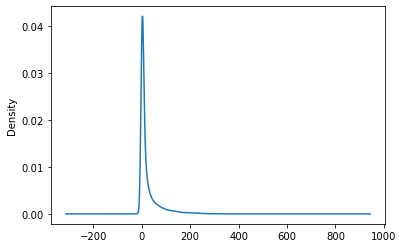

In [18]:
airbnb['number_of_reviews'].plot(kind = 'density');

Because we are looking to target listings that have received no reviews, it makes more sense to covert the number of reviews into binary classes (1 for 'has reviews' and 0 for 'does not have reviews')

In [19]:
# Encode target variable as 0 (no reviews) or 1 (reviews)

def encode_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    Replace the 'number of reviews' column with a 'has reviews' column that is
    1 if number of reviews > 0 and 0 if number of reviews = 0
    Return the dataframe.
    """
    feature_col = 'number_of_reviews'
    new_df = df.copy()
    new_df['has_reviews'] = df[feature_col].apply(lambda r: 0 if r == 0 else 1)
    return new_df.drop(columns = [feature_col])

raw_train = encode_target(raw_train)
raw_test = encode_target(raw_test)

In [20]:
"""
Make a copy of the training data to explore during EDA. 
We can try transformations on this dataset to see if they improve the distributions. 
If they work, apply them to the training and test sets.
"""
eda_data = raw_train.copy()

### 2.1.4 Exploring numeric features 

Next, examine the distribution of numeric features.

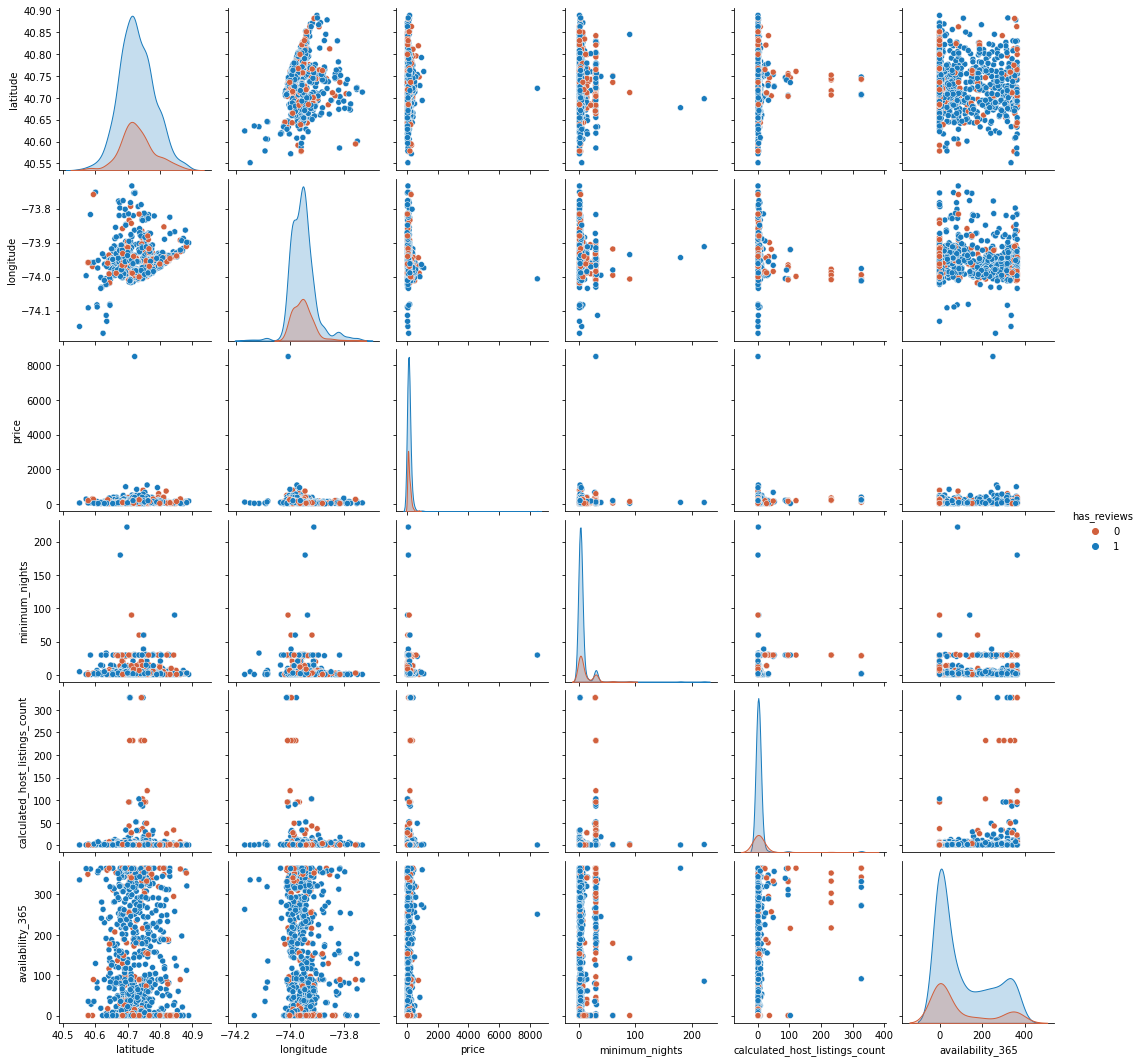

In [21]:
### Numerical attributes

palette = {
    1: '#197BBD',
    0: '#D1603D'
}

numerical_data = eda_data.select_dtypes('number')
sns.pairplot(numerical_data.sample(1000), hue = 'has_reviews', palette = palette);

There don't appear to be any obvious correlations between the variables, other than that potentially price tends to be higher towards the centre of the city (mid-ranged longitude and latitude).

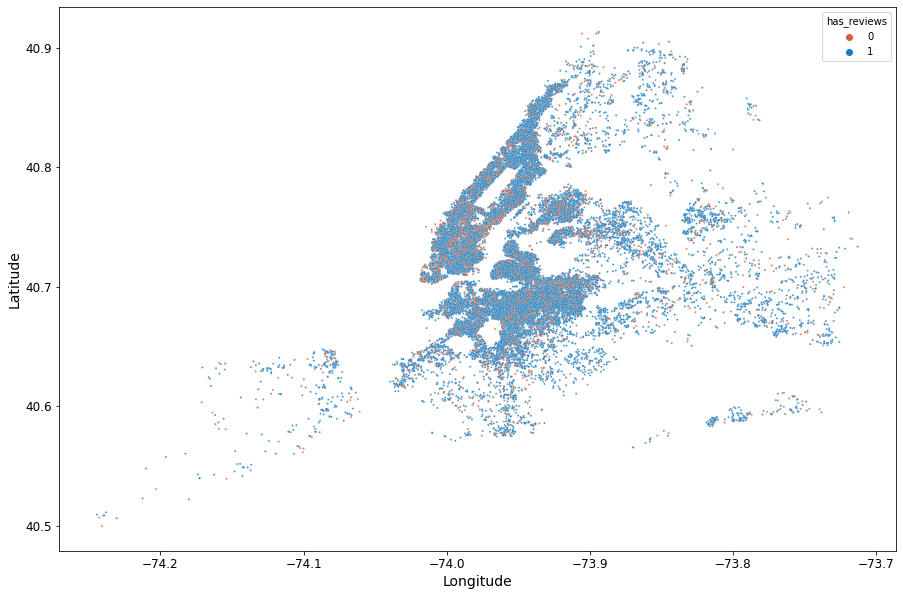

In [22]:
palette = {
    1: '#197BBD',
    0: '#D1603D'
}
fontcolor = 'black'

fig, ax = plt.subplots(figsize = (15,10))
sns.scatterplot(data = eda_data, x = 'longitude',  y = 'latitude', hue = 'has_reviews', alpha = 0.8, s = 4, palette = palette)
ax.set_ylabel('Latitude', fontsize = 14, color = fontcolor)
ax.set_xlabel('Longitude', fontsize = 14, color = fontcolor)

ax.tick_params(labelcolor = fontcolor, color = fontcolor, labelsize = 12);

It does not appear that there are areas with a higher density of listings without reviews, but this is hard to inspect by eye.

In [23]:
def plot_distribution(df: pd.DataFrame, col_of_interest: str, title = None, color_split = 'has_reviews', fontsize = 14) -> plt.Axes:
    """
    Plot the distribution of the given column of df as a density plot with an accompanying rugplot.
    The data is split into two groups (based on the column supplied as 'color_split')
    """
    if title == None:
        title = "Distribution of "+ col_of_interest.replace('_', ' ') + " of AirBnB listings in New York City"
    # Create figure and axes
    fig, ax = plt.subplots(figsize = (10,8))
    
    # plot each color group
    df[df[color_split]==1][col_of_interest].plot(kind = 'density', ax = ax, label = 'has reviews', color = '#197BBD')
    df[df[color_split]==0][col_of_interest].plot(kind = 'density', ax = ax, label = 'does not have reviews', color = '#D1603D')
    
    # add rugplot
    ax.plot(df[col_of_interest], [-0.0001]*len(df[col_of_interest]), '|', color='k')
    
    # Add labels, legend, and title
    ax.set_xlabel(col_of_interest.title(), fontsize = fontsize*0.9)
    ax.set_ylabel('Density', fontsize = fontsize)
    ax.legend(fontsize = fontsize*0.9)
    ax.set_title(title, fontsize = fontsize)
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    return ax

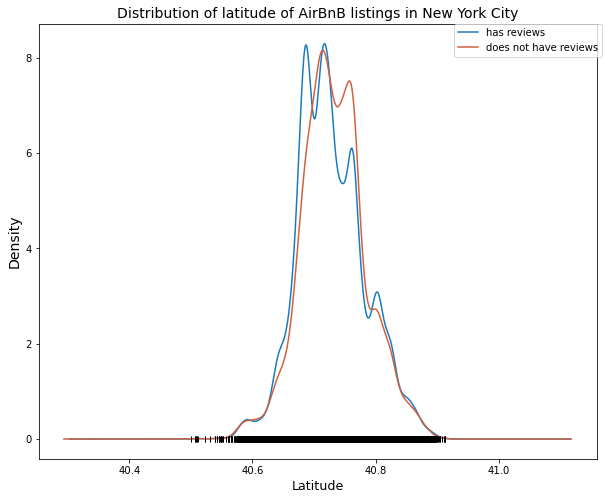

In [24]:
plot_distribution(eda_data, 'latitude');

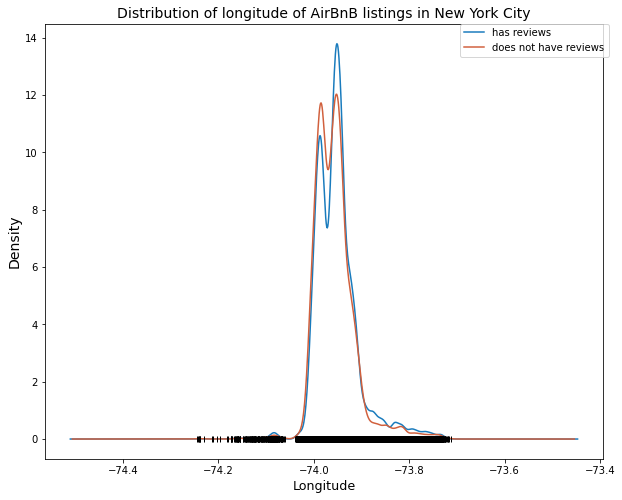

In [25]:
plot_distribution(eda_data, 'longitude');

Both latitude and longitude are approximately normally distributed so can be standardized using StandardScaler (Hale, 2019).

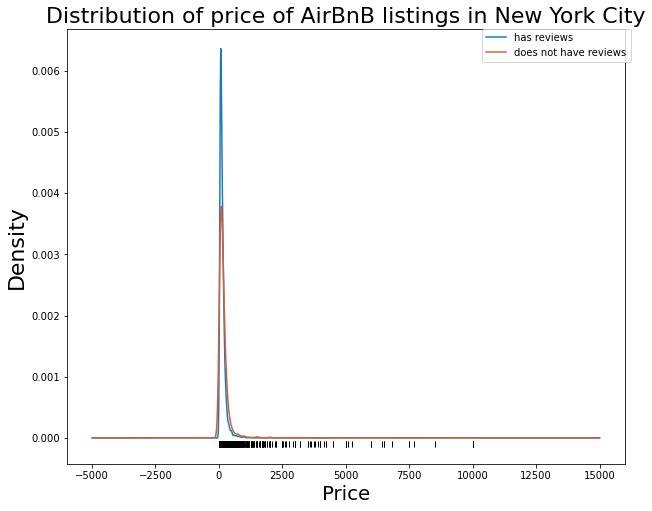

In [26]:
# this chart has a greater fontsize for inclusion in powerpoint presentation
plot_distribution(eda_data, 'price', fontsize = 22);

The price distribution looks like it might be log normal. Transform it to get a normally distributed variable.

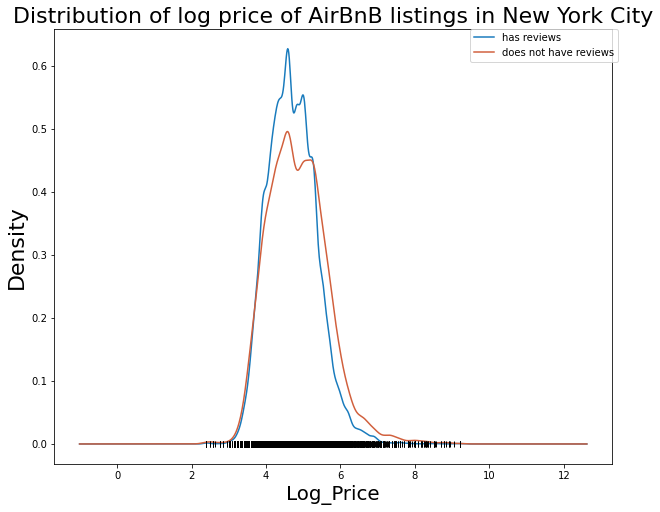

In [27]:
eda_data['log_price'] = eda_data['price'].apply(lambda p: np.log(p+1))
plot_distribution(eda_data, 'log_price', fontsize = 22);

The natural logarithm of price is approximately normally distributed so can be standardized using StandardScaler.

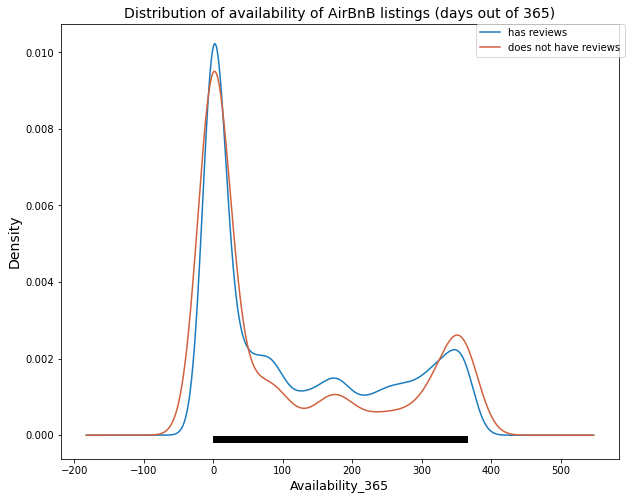

In [28]:
plot_distribution(eda_data, 'availability_365', title = 'Distribution of availability of AirBnB listings (days out of 365)');

It seems that a high proportion of listings are not actually available (availability = 0). These listings will be examined more closely. If they are not available now, have they ever been available? If any of them have reviews, it would imply that they have been available in the past.

In [29]:
eda_data[eda_data['availability_365']==0][['availability_365', 'has_reviews']].groupby(['has_reviews']).count()

availability_365
has_reviews                  
0                        3871
1                       10270

In [30]:
no_reviews = eda_data[eda_data['has_reviews']==0]

prop_unavailable = len(no_reviews[no_reviews['availability_365']==0])/len(no_reviews)

print(f"{prop_unavailable*100: .1f}% of listings without reviews have availability = 0")

 47.9% of listings without reviews have availability = 0


Many of the listings that are unavailable still have reviews. This suggests that at the time of the review(s), their availability was greater than 0. Going forward, we should bear in mind that the availability of the listings changes over time and we only have access to the value of availability at a single point in time. This might make the `availability_365` feature unreliable. We should consider removing listings where availability = 0 because

- listings that have availability = 0 and no reviews are not particularly surprising (they are probably new). We don't need a machine learning model to tell us that unavailable properties do not get booked.
- listings that have availability = 0 *and reviews* have been subject to change over time, and we do not have information about their availability before.

Because so many of the listings *without* reviews are represented by these listings, we will keep these entries for now.

Rather than applying min-max normalisation, we can bring this data into the same range as log price and the other standardized variables by converting to the fraction of the year when the property is available.

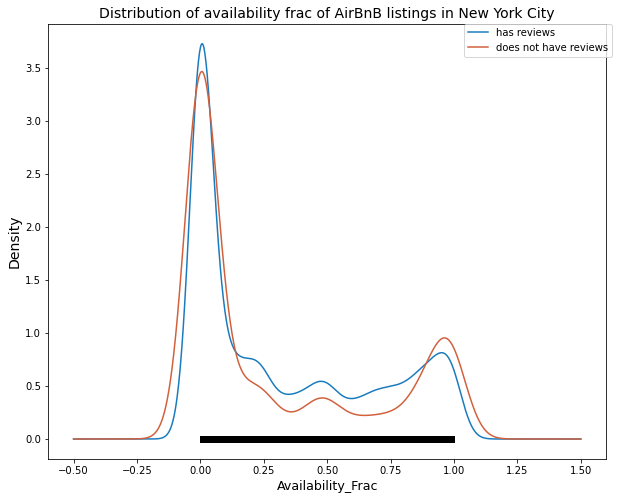

In [31]:
eda_data['availability_frac'] = eda_data['availability_365'] / 365
plot_distribution(eda_data, 'availability_frac');

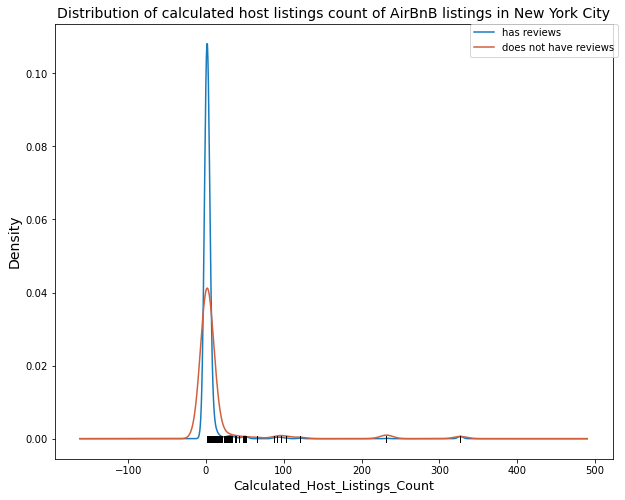

In [32]:
plot_distribution(eda_data, 'calculated_host_listings_count');

Again, this looks like a log normal distribution with some very large outliers.

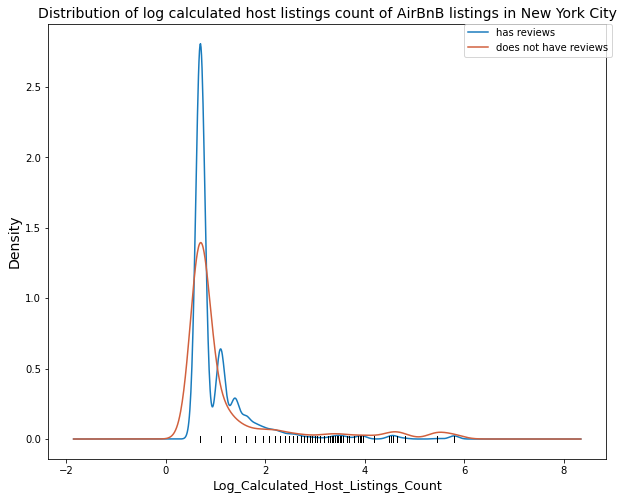

In [33]:
# since we are now performing log twice we should create a function that we will apply to the test and training data.
def transform_log_normal_variables(df: pd.DataFrame, columns_to_transform: List[str], drop = True) -> pd.DataFrame:
    """
    Takes the natural logarithm of the given columns of the dataframe. 
    Drops original columns unless otherwise specified.
    """
    new_df = df.copy()
    for col in columns_to_transform:
        new_column = 'log_' + col
        new_df[new_column] = new_df[col].apply(lambda x: np.log(x+1)) # prevent ln 0 errors
    if drop:
        new_df.drop(columns = columns_to_transform, inplace = True)
    return new_df

eda_data = transform_log_normal_variables(eda_data, ['calculated_host_listings_count'], drop = False)
plot_distribution(eda_data, 'log_calculated_host_listings_count');

On inspection it does not appear to be a log normal distribution. The data is bounded by 0 and has a long tail in the positive direction. The Min-max scaler should be used for this variable as it is not normally distributed (Hale, 2019).

In [34]:
# remove the log-transformed host listings count feature
eda_data.drop(columns= ['log_calculated_host_listings_count'], inplace = True);

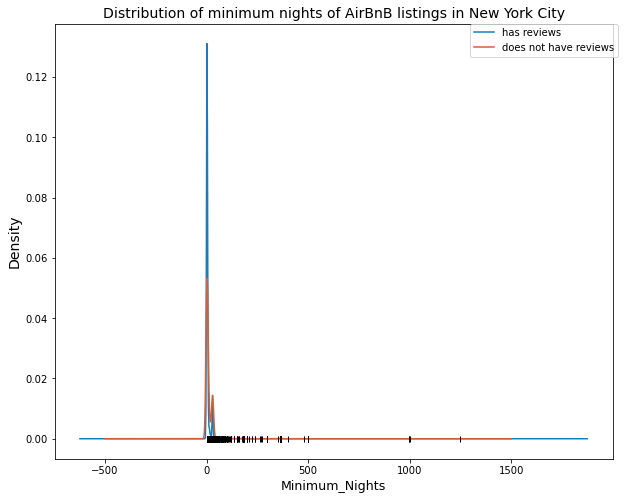

In [35]:
plot_distribution(eda_data, 'minimum_nights');

This variable also has some extreme outliers. Minimum nights greater than a few months lean more towards tenancy than holiday stay, but there are laws in New York City that prevent properties in certain building types from being let for less than 30 days without the host present (New York State, 1929, p.4). For this reason minimum night stays greater than 30 days will not be considered outliers.

We will create an OutlierRemover than can be used to strip outliers from the training data to see if it improves model performance. For visualisation purposes the outliers will be removed.

In [36]:
eda_data.isna().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
calculated_host_listings_count    0
availability_365                  0
has_reviews                       0
log_price                         0
availability_frac                 0
dtype: int64

2148 observations removed (5.42%)


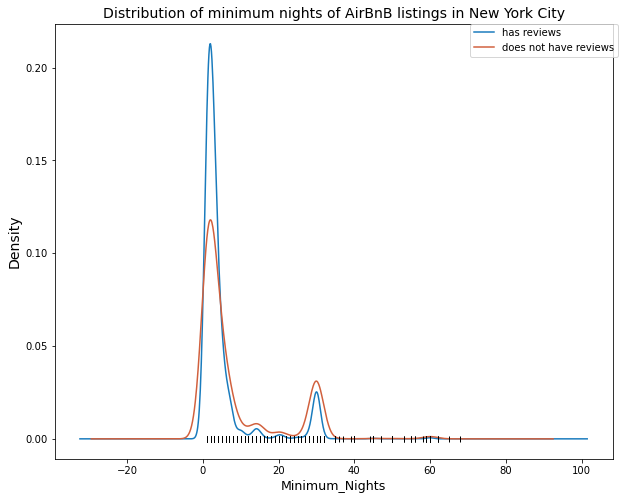

In [37]:
class OutlierRemover:
    def __init__(self, min_z_score = -3, max_z_score = 3):
        """
        Set minimum and maximum z score for value NOT to be considered an outlier.
        """
        self.min_z_score = min_z_score
        self.max_z_score = max_z_score
        # Create empty dictionary to store mean & standard deviation of each column
        self.means_sds = {}
        # Create list to store column names
        self.list_of_columns = []
    def fit(self, data: pd.DataFrame, list_of_columns = []):
        """
        Calculate the mean and standard deviation of each column
        """
        if len(list_of_columns)==0:
            list_of_columns = data.columns
        self.list_of_columns = list_of_columns
        for col in list_of_columns:
            mean = data[col].mean()
            sd = np.sqrt(data[col].var())
            self.means_sds[col] = (mean, sd)
    def calculate_z_score(self, value: float, col: str) -> float:
        """
        Calculate the z_score of the given value given the column's mean and S.D.
        """
        return (value - self.means_sds[col][0])/self.means_sds[col][1]
    def transform(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Remove all rows contain values that are outside of the allowed Z score range.
        """
        if len(self.means_sds.keys())==0:
            print("Transformer must be fit before transformation. Call .fit(data) or .fit_transform(data)")
            return
        for col in self.list_of_columns:
            z_scores = data[col].apply(self.calculate_z_score, col=col)
            data = data[(z_scores>self.min_z_score)&(z_scores<self.max_z_score)]
        return data
    def fit_transform(self, data: pd.DataFrame, list_of_cols = []) -> pd.DataFrame:
        """
        Fit the OutlierRemover to the dataframe and transform it.
        """
        self.fit(data, list_of_cols)
        return self.transform(data)

o_r = OutlierRemover(-3, 3)

# only work with the numerical features
numerical_features = eda_data.select_dtypes('number')
numerical_transformed = o_r.fit_transform(numerical_features)
# fit and transform with the OutlierRemover
eda_data[numerical_features.columns] = numerical_transformed

# Record the difference
orig_len = len(eda_data)
obs_removed = orig_len - len(numerical_transformed)
print(f'{obs_removed} observations removed ({round(obs_removed/orig_len*100, 2)}%)')

# Drop the NAs (these are the outlier rows)
eda_data.dropna(inplace = True)
eda_data.head()
plot_distribution(eda_data, 'minimum_nights');

### 2.1.5 Exploring categorical features

Explore the categorical features in order to decide which to select for the model and how to encode them.

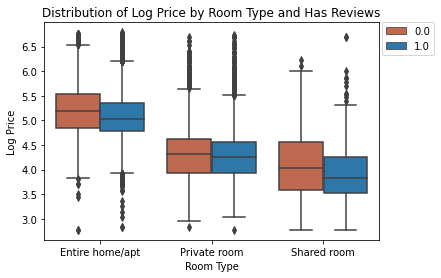

In [38]:
def reformat_feature_name(feature_name: str) -> str:
    """
    Return the given name in title case with underscores replaced with spaces
    """
    return feature_name.title().replace('_', ' ')

def boxplot(data: pd.DataFrame, x: str, y:str, hue:str, palette:Dict, title = None):
    """
    Plot a boxplot of the distribution of the given y value against the given x value, coloured by the hue value.
    """
    ax = sns.boxplot(data = data, x = x, y = y, hue = hue, palette = palette)
    
    # generate labels from feature names
    x_label = reformat_feature_name(x)
    y_label = reformat_feature_name(y)
    
    if title == None:
        title = f"Distribution of {y_label} by {x_label} and {reformat_feature_name(hue)}"
        
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0);

boxplot(data = eda_data, x = 'room_type', y = 'log_price', hue = 'has_reviews', palette = palette);

There are no obvious differences in price range between the room types for listings that have reviews and those that have no reviews. Overall, "Entire home/apt" listings tend to cost more than "Private room" listings, which tend to cost more than "Shared room" listings.

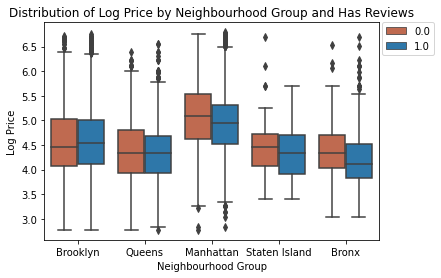

In [39]:
boxplot(data = eda_data, x = 'neighbourhood_group', y = 'log_price', hue = 'has_reviews', palette = palette);

In some neighbourhood groups the median price of listings without reviews is slightly lower than the median price of listings with reviews. In Brooklyn this trend is reversed.

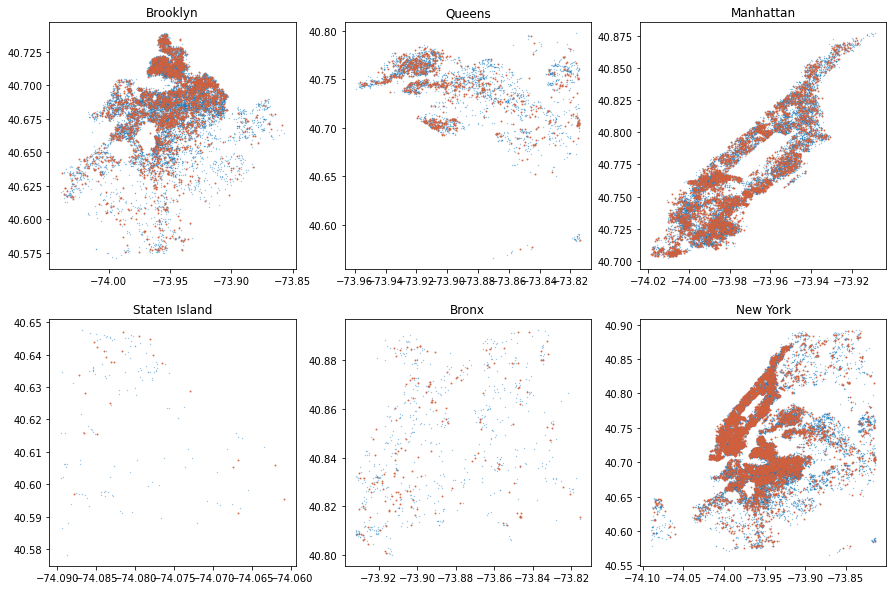

In [40]:
fig, axs = plt.subplots(ncols = 3, nrows =2, figsize = (15,10))

neighs = eda_data['neighbourhood_group'].unique().tolist() + ['New York']
i = 0

for row in range(2):
    for col in range(3):
        if i < 5:
            neigh_dat = eda_data[eda_data['neighbourhood_group']==neighs[i]]
        else:
            neigh_dat = eda_data
        axs[row, col].scatter(x = neigh_dat[neigh_dat['has_reviews']==1]['longitude'],
                              y = neigh_dat[neigh_dat['has_reviews']==1]['latitude'],
                              color = '#197BBD', s = 0.1, alpha = 0.6)
        axs[row, col].scatter(x = neigh_dat[neigh_dat['has_reviews']==0]['longitude'],
                              y = neigh_dat[neigh_dat['has_reviews']==0]['latitude'],
                              color = '#D1603D', s = 1, alpha = 0.8)
        axs[row, col].set_title(neighs[i])
        i+=1

It doesn't appear that location has an impact on whether or not a listing has reviews - there is a mixture of both in each neighbourhood and fairly well distributed.

The latitude and longitude will be included anyway, to see if there is a relationship influenced by another factor.

Even though one could argue that entire home is "better" than private room, assigning the room types values 1, 2, and 3 would assume that they are equally spaced. These  values will be one hot encoded instead.
For now, neighbourhood and neighbourhood group will **not** be used - the assumption is that the information about vicinity is adequately encoded by latitude and longitude. They can be brought back in later if needed.



In [41]:
ohe = OneHotEncoder()

def adjust_column_headers(col: str):
    """
    Replace spaces with underscores in column name
    """
    return col.lower().replace(' ', '_')

def one_hot_encode(df: pd.DataFrame, col_to_encode: str, ohe: OneHotEncoder, fit = True, col_to_drop = None) -> pd.DataFrame:
    """
    Transform the given column of the dataframe using the one hot encoder.
    Only fit the OHE to the data if `fit` is True.
    Drop the original column and optional additional columns.
    """
    data_to_encode = df[[col_to_encode]]
    if fit:
        ohe_data_array = ohe.fit_transform(data_to_encode).toarray()
    else:
        ohe_data_array = ohe.transform(data_to_encode).toarray()
    # get new column names
    column_names = ohe.get_feature_names([col_to_encode])
    column_names = [adjust_column_headers(col) for col in column_names]
    col_to_drop = col_to_encode + '_' + adjust_column_headers(col_to_drop)
    ohe_data = pd.DataFrame(data = ohe_data_array, columns = column_names)
    if col_to_drop is None:
        cols_to_drop = [col_to_encode]
    else:
        cols_to_drop = [col_to_encode, col_to_drop]
    # concatentate the dataframe with the one hot encoded data, dropping the unwanted columns.
    new_df = pd.concat([df.reset_index(drop = True), ohe_data], axis = 1).drop(columns = cols_to_drop)
    return new_df
    
# Can drop 'shared room' as it is implied if both 'private room' and 'entire home' are 0
eda_data = one_hot_encode(eda_data, 'room_type', ohe, col_to_drop = 'Shared room')
eda_data.head()

neighbourhood_group       neighbourhood  latitude  longitude  price  \
0            Brooklyn        Williamsburg  40.71756  -73.95579  165.0   
1            Brooklyn  Bedford-Stuyvesant  40.68631  -73.92629  200.0   
2              Queens             Astoria  40.76413  -73.92374   98.0   
3            Brooklyn            Bushwick  40.69738  -73.92947  160.0   
4           Manhattan             Midtown  40.74897  -73.98265  500.0   

   minimum_nights  calculated_host_listings_count  availability_365  \
0             8.0                             1.0             297.0   
1             2.0                             1.0               0.0   
2             6.0                             1.0             306.0   
3             3.0                             1.0             270.0   
4             5.0                             1.0               0.0   

   has_reviews  log_price  availability_frac  room_type_entire_home/apt  \
0          1.0   5.111988           0.813699                        1.0   
1          0.0   5.303305           0.000000                        0.0   
2          1.0   4.595120           0.838356                        1.0   
3          1.0   5.081404           0.739726                        1.0   
4          0.0   6.216606           0.000000                        0.0   

   room_type_private_room  
0                     0.0  
1                     1.0  
2                     0.0  
3                     0.0  
4                     1.0

Before attempting to visualise two or three variables together, the data will be scaled.

In [42]:
def scale_data(df: pd.DataFrame, columns_to_transform: List[str], scaler, fit = True, drop = True) -> pd.DataFrame:
    """
    Optionally fit, and transform the given columns of the dataframe using the supplied scaler. 
    Drop original columns if True.
    """
    data_to_transform = df.copy()[columns_to_transform]
    scaled_data = scaler.fit_transform(data_to_transform)
    new_cols = ['scaled_' + col for col in columns_to_transform]
    df[new_cols] = scaled_data
    if drop:
        df.drop(columns=columns_to_transform, inplace = True)
    return df

eda_data_scaled = scale_data(eda_data,['minimum_nights', 'calculated_host_listings_count'], MinMaxScaler(), drop = False)
eda_data_scaled = scale_data(eda_data_scaled, ['longitude', 'latitude', 'price', 'log_price'], StandardScaler(), drop = False)
eda_data_scaled.sample(12)

neighbourhood_group              neighbourhood  latitude  longitude  \
10421           Manhattan         Financial District  40.70725  -74.00206   
21958            Brooklyn                  Gravesend  40.59301  -73.97500   
34247           Manhattan               East Village  40.72157  -73.97861   
20038           Manhattan          Flatiron District  40.74107  -73.98800   
37363            Brooklyn  Prospect-Lefferts Gardens  40.65912  -73.94735   
3350             Brooklyn                   Bushwick  40.69555  -73.93069   
21626              Queens           Ditmars Steinway  40.77560  -73.90825   
29848           Manhattan                    Midtown  40.74873  -73.98827   
679              Brooklyn               Williamsburg  40.70230  -73.94190   
31606              Queens                     Corona  40.74322  -73.86005   
8772            Manhattan               West Village  40.73433  -74.00588   
32379            Brooklyn                Fort Greene  40.69564  -73.97287   

       price  minimum_nights  calculated_host_listings_count  \
10421  160.0             6.0                             1.0   
21958  140.0             3.0                             2.0   
34247   71.0             7.0                             1.0   
20038  112.0             4.0                             2.0   
37363   44.0             1.0                             1.0   
3350    95.0             1.0                             4.0   
21626   70.0             1.0                             1.0   
29848  159.0             7.0                             1.0   
679     65.0             3.0                             1.0   
31606   65.0             1.0                             3.0   
8772   250.0             2.0                             1.0   
32379   77.0             1.0                             2.0   

       availability_365  has_reviews  log_price  availability_frac  \
10421               0.0          1.0   5.081404           0.000000   
21958             222.0          1.0   4.948760           0.608219   
34247               0.0          1.0   4.276666           0.000000   
20038               1.0          1.0   4.727388           0.002740   
37363              89.0          1.0   3.806662           0.243836   
3350              193.0          1.0   4.564348           0.528767   
21626               0.0          0.0   4.262680           0.000000   
29848               0.0          0.0   5.075174           0.000000   
679               238.0          1.0   4.189655           0.652055   
31606             333.0          1.0   4.189655           0.912329   
8772              222.0          1.0   5.525453           0.608219   
32379             364.0          1.0   4.356709           0.997260   

       room_type_entire_home/apt  room_type_private_room  \
10421                        1.0                     0.0   
21958                        1.0                     0.0   
34247                        0.0                     1.0   
20038                        0.0                     1.0   
37363                        1.0                     0.0   
3350                         1.0                     0.0   
21626                        0.0                     1.0   
29848                        1.0                     0.0   
679                          0.0                     1.0   
31606                        0.0                     1.0   
8772                         1.0                     0.0   
32379                        0.0                     1.0   

       scaled_minimum_nights  scaled_calculated_host_listings_count  \
10421               0.074627                               0.000000   
21958               0.029851                               0.009804   
34247               0.089552                               0.000000   
20038               0.044776                               0.009804   
37363               0.000000                               0.000000   
3350                0.000000                         

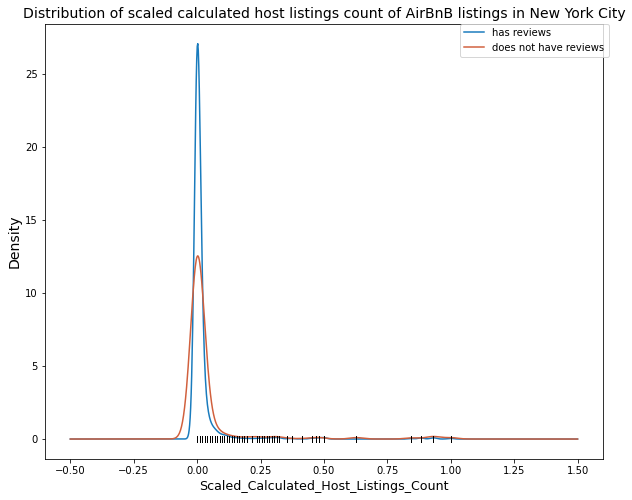

In [43]:
plot_distribution(eda_data_scaled, 'scaled_calculated_host_listings_count');

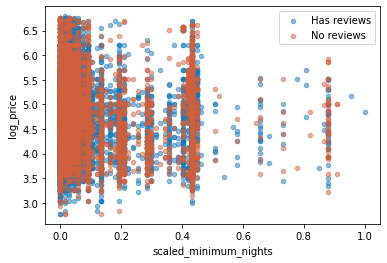

In [44]:
def plot_two_variables(df:pd.DataFrame, var1: str, var2: str, 
                       color_col = 'has_reviews', label1 = 'Has reviews', label0 = 'No reviews'):
    """
    Plot two variables of a dataframe against one another as a scatter graph, to look for any sign of correlation.
    Color the points by the "color_col" variable.
    """
    ax = df[df[color_col]==1].plot(kind = 'scatter', x = var1, y = var2, 
                                  label = label1, color = '#197BBD', 
                                  alpha = 0.5)
    df[df[color_col]==0].plot(kind = 'scatter',x = var1, y = var2, 
                                       label = label0, color = '#D1603D',
                                       alpha = 0.5, ax=ax)
    ax.legend()
    return ax;
    
plot_two_variables(eda_data, 'scaled_minimum_nights',  'log_price');

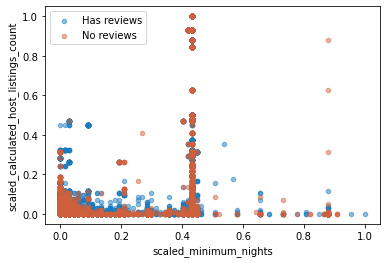

In [45]:
plot_two_variables(eda_data, 'scaled_minimum_nights', 'scaled_calculated_host_listings_count');

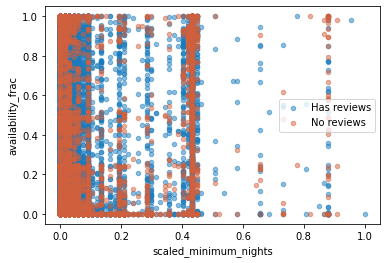

In [46]:
plot_two_variables(eda_data, 'scaled_minimum_nights', 'availability_frac');

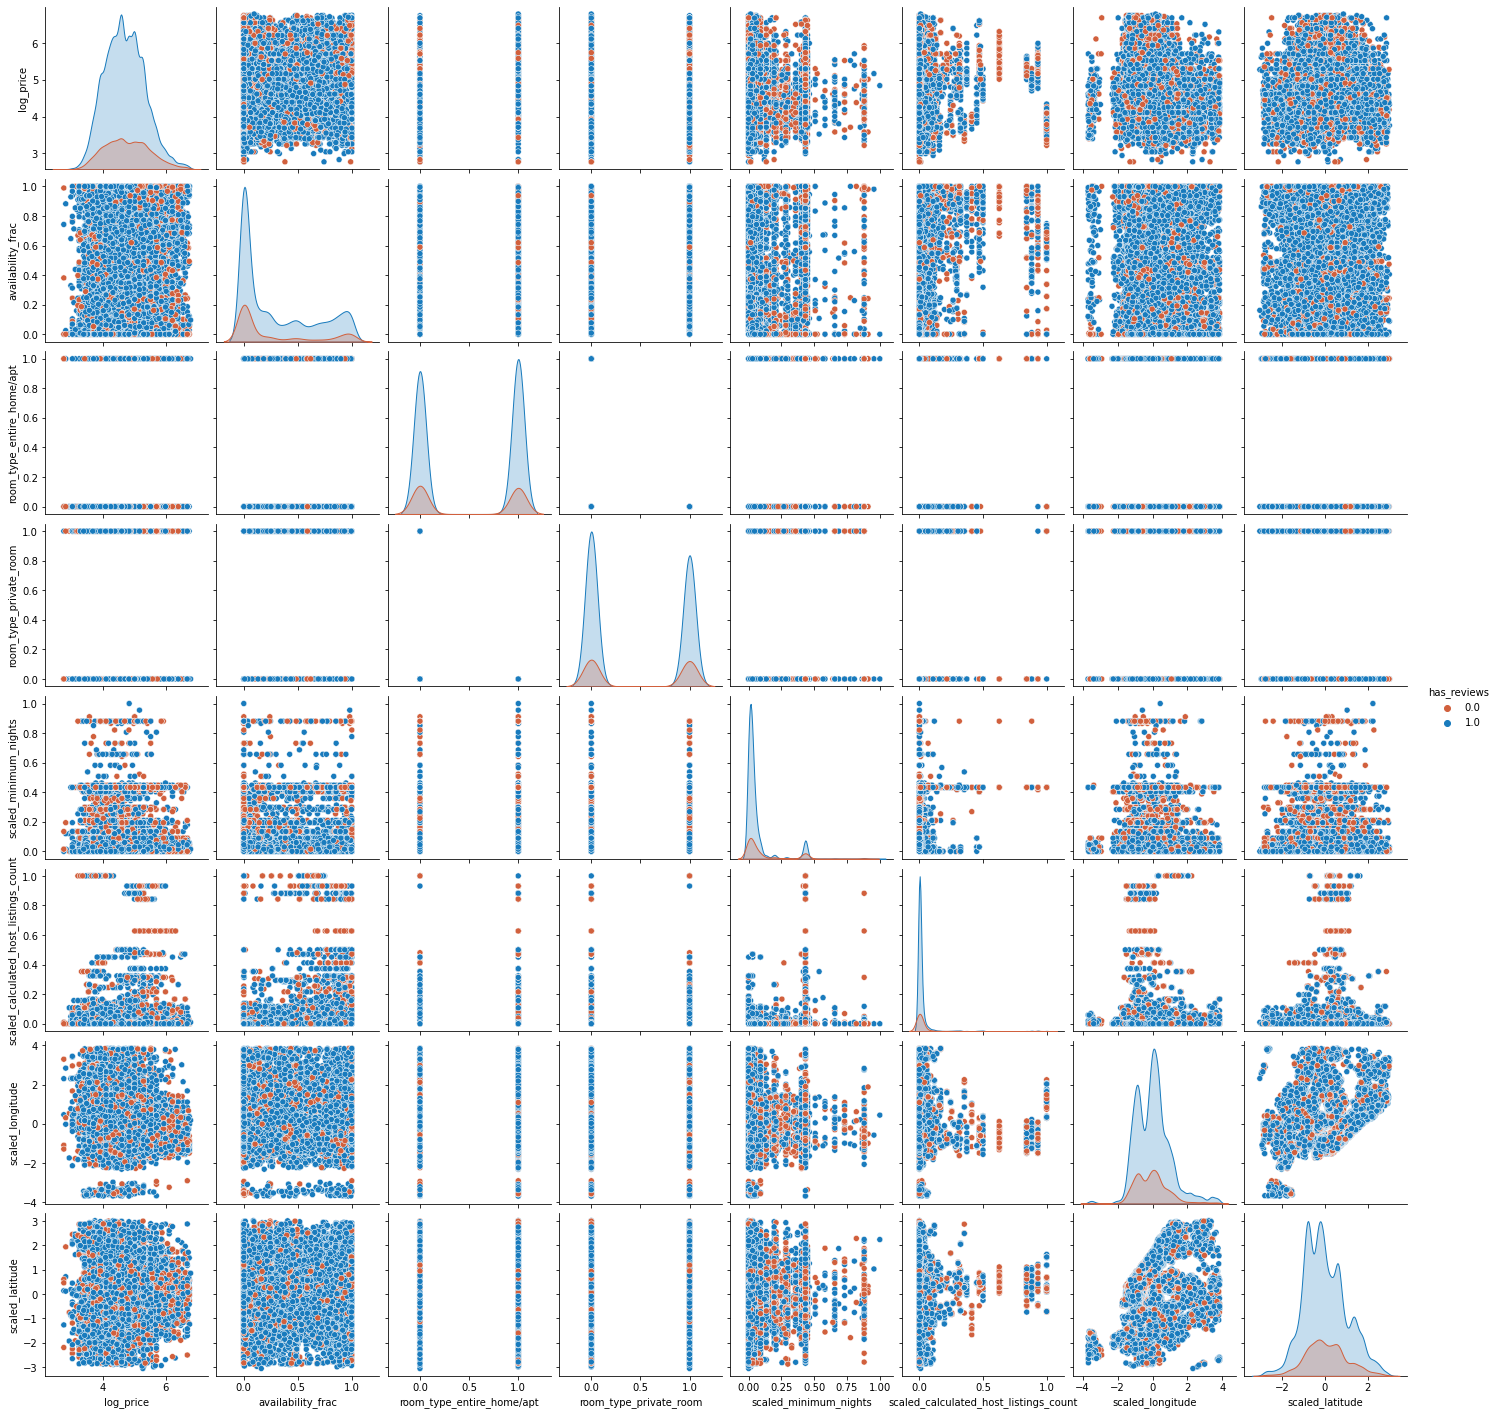

In [47]:
sns.pairplot(eda_data[['has_reviews', 'log_price', 'availability_frac', 'room_type_entire_home/apt',
       'room_type_private_room', 'scaled_minimum_nights',
       'scaled_calculated_host_listings_count', 'scaled_longitude',
       'scaled_latitude']], hue = 'has_reviews', palette = palette)

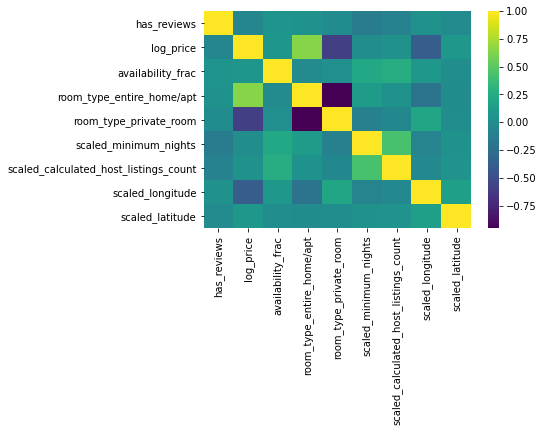

In [48]:
corrMatrix = eda_data[['has_reviews', 'log_price', 'availability_frac', 'room_type_entire_home/apt',
       'room_type_private_room', 'scaled_minimum_nights',
       'scaled_calculated_host_listings_count', 'scaled_longitude',
       'scaled_latitude']].corr()
sns.heatmap(corrMatrix, cmap = 'viridis');

All of the preprocessing steps above will be repeated on X_train and X_test (transformers will be fit only on X_train).
    

In [49]:
eda_data.head()

neighbourhood_group       neighbourhood  latitude  longitude  price  \
0            Brooklyn        Williamsburg  40.71756  -73.95579  165.0   
1            Brooklyn  Bedford-Stuyvesant  40.68631  -73.92629  200.0   
2              Queens             Astoria  40.76413  -73.92374   98.0   
3            Brooklyn            Bushwick  40.69738  -73.92947  160.0   
4           Manhattan             Midtown  40.74897  -73.98265  500.0   

   minimum_nights  calculated_host_listings_count  availability_365  \
0             8.0                             1.0             297.0   
1             2.0                             1.0               0.0   
2             6.0                             1.0             306.0   
3             3.0                             1.0             270.0   
4             5.0                             1.0               0.0   

   has_reviews  log_price  availability_frac  room_type_entire_home/apt  \
0          1.0   5.111988           0.813699                        1.0   
1          0.0   5.303305           0.000000                        0.0   
2          1.0   4.595120           0.838356                        1.0   
3          1.0   5.081404           0.739726                        1.0   
4          0.0   6.216606           0.000000                        0.0   

   room_type_private_room  scaled_minimum_nights  \
0                     0.0               0.104478   
1                     1.0               0.014925   
2                     0.0               0.074627   
3                     0.0               0.029851   
4                     1.0               0.059701   

   scaled_calculated_host_listings_count  scaled_longitude  scaled_latitude  \
0                                    0.0         -0.032198        -0.232009   
1                                    0.0          0.774059        -0.812555   
2                                    0.0          0.843752         0.633144   
3                                    0.0          0.687147        -0.606903   
4                                    0.0         -0.766302         0.351509   

   scaled_price  scaled_log_price  
0      0.252542          0.615760  
1      0.579816          0.912575  
2     -0.373952         -0.186126  
3      0.205789          0.568311  
4      3.385016          2.329499

## 2.2 Data pre-processing

### 2.2.1 Transformations

Functions will be written that will apply all of the transformations (including scaling and one hot encoding) to the train and test datasets. This is so that the transformations can be applied repeatedly as we experiment with different methods.

In [50]:
def convert_availability_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Change the availability column from a value out of 365 to a fraction of 1.
    Rename the column accordingly.
    """
    new_df = df.copy()
    new_df['availability_frac'] = new_df['availability_365'] / 365
    new_df.drop(columns = ['availability_365'], inplace = True)
    return new_df

def apply_transformations(df: pd.DataFrame,
                          one_hot_encoder: OneHotEncoder, 
                          minmax_scaler: MinMaxScaler, 
                          standard_scaler: StandardScaler, 
                          fit = False):
    """
    Apply pre-processing transformations to the columns of the dataframe:
        - convert availability column
        - log transform price columns
        - one hot encoding of room type column
        - min-max scaling of non-normally distributed variables
        - standard scaling of normally distributed variables
    Only fit the scalers to the dataframe if fit = True (i.e. training set)
    """
    new_df = convert_availability_column(df)
    log_df = transform_log_normal_variables(new_df, ['price'], drop = True)
    ohe_df = one_hot_encode(log_df, 'room_type', one_hot_encoder, col_to_drop = 'Shared room', fit = fit)
    minmax_scaled_df = scale_data(ohe_df, ['minimum_nights', 'calculated_host_listings_count'], 
                                  minmax_scaler, drop = True, fit = fit)
    standard_scaled_df = scale_data(minmax_scaled_df, ['longitude', 'latitude', 'log_price'],
                                   standard_scaler, drop = True, fit = fit)
    return standard_scaled_df

# Initialise transformers
one_hot_encoder = OneHotEncoder()
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
outlier_remover = OutlierRemover()

# apply transformations to training set (fit transformers)
proc_train = apply_transformations(raw_train,
                                   one_hot_encoder,
                                   minmax_scaler,
                                   standard_scaler,
                                   fit = True)

# apply transformations to test set (do not fit transformers)
proc_test = apply_transformations(raw_test,
                                  one_hot_encoder,
                                  minmax_scaler,
                                  standard_scaler,
                                  fit = False)
proc_train.head()

neighbourhood_group       neighbourhood  has_reviews  availability_frac  \
0            Brooklyn        Williamsburg            1           0.813699   
1            Brooklyn  Bedford-Stuyvesant            0           0.000000   
2              Queens             Astoria            1           0.838356   
3            Brooklyn            Bushwick            1           0.739726   
4           Manhattan             Midtown            0           0.000000   

   room_type_entire_home/apt  room_type_private_room  scaled_minimum_nights  \
0                        1.0                     0.0               0.005604   
1                        0.0                     1.0               0.000801   
2                        1.0                     0.0               0.004003   
3                        1.0                     0.0               0.001601   
4                        0.0                     1.0               0.003203   

   scaled_calculated_host_listings_count  scaled_longitude  scaled_latitude  \
0                                    0.0         -0.079458        -0.211645   
1                                    0.0          0.560400        -0.784622   
2                                    0.0          0.615710         0.642227   
3                                    0.0          0.491425        -0.581651   
4                                    0.0         -0.662054         0.364265   

   scaled_log_price  
0          0.540929  
1          0.817611  
2         -0.206565  
3          0.496699  
4          2.138426

In [51]:
proc_train.describe()

has_reviews  availability_frac  room_type_entire_home/apt  \
count  39595.000000       39595.000000               39595.000000   
mean       0.795959           0.309867                   0.519485   
std        0.403004           0.360660                   0.499627   
min        0.000000           0.000000                   0.000000   
25%        1.000000           0.000000                   0.000000   
50%        1.000000           0.123288                   1.000000   
75%        1.000000           0.624658                   1.000000   
max        1.000000           1.000000                   1.000000   

       room_type_private_room  scaled_minimum_nights  \
count            39595.000000           39595.000000   
mean                 0.457103               0.004850   
std                  0.498163               0.016624   
min                  0.000000               0.000000   
25%                  0.000000               0.000000   
50%                  0.000000               0.001601   
75%                  1.000000               0.003203   
max                  1.000000               1.000000   

       scaled_calculated_host_listings_count  scaled_longitude  \
count                           39595.000000      3.959500e+04   
mean                                0.018929      2.198819e-14   
std                                 0.101216      1.000013e+00   
min                                 0.000000     -6.339869e+00   
25%                                 0.000000     -6.712720e-01   
50%                                 0.000000     -7.663814e-02   
75%                                 0.003067      3.438243e-01   
max                                 1.000000      5.186896e+00   

       scaled_latitude  scaled_log_price  
count     3.959500e+04      3.959500e+04  
mean     -7.097335e-14     -3.561770e-16  
std       1.000013e+00      1.000013e+00  
min      -4.204511e+00     -3.384188e+00  
25%      -7.142143e-01     -7.078532e-01  
50%      -1.064010e-01     -1.077619e-01  
75%       6.256336e-01      6.255258e-01  
max       3.372895e+00      6.468106e+00

### 2.2.2 Feature Selection

Given that there was no obvious difference in the distribution of listings with and without reviews in the different neighbourhood groups, we will assume that longitude and latitude are sufficient to group listings geographically.

In [52]:
cols_to_drop = ['neighbourhood_group', 'neighbourhood']

# save for later
neighbourhood_info_tr = proc_train[cols_to_drop]
neighbourhood_info_ts = proc_test[cols_to_drop]

proc_train.drop(columns = cols_to_drop, inplace = True)
proc_test.drop(columns = cols_to_drop, inplace = True)

print("This leaves us with the following columns:\n")
for col in proc_train.columns:
    print("\t"+col)

This leaves us with the following columns:

	has_reviews
	availability_frac
	room_type_entire_home/apt
	room_type_private_room
	scaled_minimum_nights
	scaled_calculated_host_listings_count
	scaled_longitude
	scaled_latitude
	scaled_log_price


We should keep an eye on what proportion of our dataset contains listings with availability = 0.

In [53]:
len(proc_train[proc_train['availability_frac']==0])/len(proc_train)

0.3571410531632782

Remove the target variable from the dataset.

In [54]:
y_train = proc_train.pop('has_reviews')
X_train = proc_train.copy()

y_test = proc_test.pop('has_reviews')
X_test = proc_test.copy()

In [55]:
# Convert X_train, X_test, y_train, and y_test to numpy

X_train_np, X_test_np, y_train_np, y_test_np =  [df.to_numpy() for df in [X_train, X_test, y_train, y_test]]

y_train_np.shape

(39595,)

## 2.3  Statistics-based data analytics

### 2.3.1 Evaluation metric

In order to compare model performance, an evaluation metric must be selected. For classification tasks, there are several options, including accuracy, recall, or precision of the positive or negative class, or metrics that combine these such as the weighted mean of accuracy or F1 score.

In this case, an ideal model will balance capturing as many listings that will not be reviewed as possible (recall), without inadvertently capturing too many listings that actually will receive reviews (precision). This is because the goal is to support Airbnb hosts in choosing settings for their listings that will get them reviews, by intervening when poor-performing settings are selected. It would not be ideal to intervene too often when hosts are actually likely to be successful. Therefore, F1 score should be used as the evaluation metric; it is the harmonic mean of precision and recall.

Recall is the ratio of correctly identified true labels to all true values in the dataset, that is:

$$Recall = \frac {True Positives (TP)}{True Positives (TP) + False Negatives (FN)} \$$

Precision is the ratio of correctly identified true labels to all the predicted true labels, that is:

$$Precision = \frac {True Positives (TP)}{True positives (TP) + False Positives (FP)} \$$

F1 score is the harmonic mean of the two:

$$F1  Score = 2 \times \frac{Precision \times Recall} {Precision + Recall} \$$

Throughout the notebook, the 0 class will be considered as the positive class, because our focus is on identifying the listings *without* reviews, not so much those ones with reviews. 

### 2.3.2 Model comparison

Four models will be compared in an attempt to balance interpretability and F1 score:

- Logistic Regression, which is a very interpretable model because its coefficients can be easily obtained.
- Decision Tree, which is interpretable through the logical "decision" made by the algorithm, i.e. how the values are split at each node.
- Random Forest, which is an ensemble method that combines the output of many decision tree models. 
- XGBoost, which is also an ensemble method. Instead of taking the modal prediction as random forests do, in XGboost trees are built sequentially with each tree being built in such a way as to reduce the error of the previous tree (this is known as 'boosting') (Morde and Setty, 2019).

To make the comparison the F1 score on the important (negative) class will be saved to a csv file.

In [56]:
# change this if you wish to save the results elsewhere.
results_loc = 'model_comparison.csv'

# Create the file in which to store the results.
with open(results_loc, 'w', newline = '') as f:
    writer = csv.writer(f)
    writer.writerow([
        'model_name', 'number_of_features', 'downsampled_data', 
        'outliers_removed', 'f1_negative_class', 'f1_macro_average'
    ])

def calculate_f1s(y_pred: List[int], y_test: List[int]) -> Tuple[float, float]:
    """
    Calculate and return the F1 score of the 0 class and the macro average F1 score.
    """
    f1_negative_class = f1_score(y_test, y_pred, pos_label = 0)
    f1_macro_average = f1_score(y_test, y_pred, average = 'macro')
    return f1_negative_class, f1_macro_average   
    
def record_score(filename: str, 
                 model_name: str, 
                 num_features: int, 
                 downsampled: bool, 
                 outliers_removed: bool, 
                 y_pred: List[int],
                 y_test: List[int]):
    """
    Save F1 scores to csv with model name, number of features, and feature engineering steps.
    """
    with open(filename, 'a', newline = '') as f:
        writer = csv.writer(f)
        row = [model_name, num_features]
        if downsampled:
            row.append('y')
        else:
            row.append('n')
        if outliers_removed:
            row.append('y')
        else:
            row.append('n')
        row += calculate_f1s(y_pred, y_test)
        writer.writerow(row)

#### Logistic Regression

Train and evaluate a logistic regression model.

F1 scores for  Logistic Regression :

F1 score of negative class: 	 0.38683431952662717 
Macro average F1 score: 	 0.5574263461150196


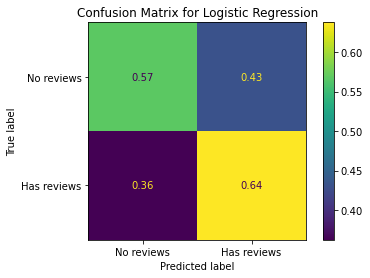

In [57]:
lr = LogisticRegression(C = 1, class_weight = 'balanced')

lr.fit(X_train_np, y_train_np)

def evaluate_model(model, 
                   X_test: pd.DataFrame, 
                   y_test: pd.Series, 
                   model_name: str) -> List[int]:
    """
    For the given model and test dataset, calculate and display the F1 scores and
    plot a confusion matrix.
    """
    # Ensure that target names are in the correct order
    target_names = []
    for y in y_test:
        if y == 0:
            target_names.append("No reviews")
        else:
            target_names.append("Has reviews")
        if len(target_names)==2:
            break
    # get predictions
    y_pred = model.predict(X_test)
    # calculate and display F1 scores
    f1_negative_class, f1_macro_average = calculate_f1s(y_pred, y_test)
    print("F1 scores for ", model_name, ":\n")
    print("F1 score of negative class: \t", f1_negative_class,
         "\nMacro average F1 score: \t", f1_macro_average)
    # plot confusion matrix
    ax = plot_confusion_matrix(model, 
                      X_test, 
                      y_test, 
                      normalize = 'true', 
                      display_labels = ['No reviews', 'Has reviews'])
    plt.title("Confusion Matrix for " + model_name);
    return y_pred

y_pred = evaluate_model(lr, X_test_np, y_test_np, "Logistic Regression");

record_score(results_loc,
             "Logistic Regression", X_train_np.shape[1],
             False, False, y_pred, y_test)

In [58]:
classif_report = classification_report(y_test_np, y_pred, target_names=["No reviews", "Has reviews"])
print(classif_report)

              precision    recall  f1-score   support

  No reviews       0.29      0.57      0.39       920
 Has reviews       0.85      0.64      0.73      3480

    accuracy                           0.62      4400
   macro avg       0.57      0.60      0.56      4400
weighted avg       0.73      0.62      0.66      4400



#### Decision Tree

F1 scores for  Decision Tree :

F1 score of negative class: 	 0.3659043659043659 
Macro average F1 score: 	 0.5942378141331022


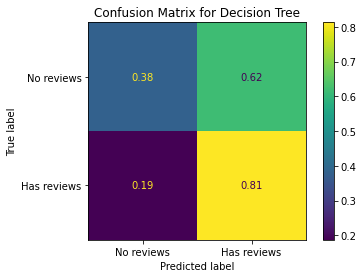

In [59]:
tree = DecisionTreeClassifier()

tree.fit(X_train_np, y_train_np)

y_pred = evaluate_model(DecisionTreeClassifier().fit(X_train_np, y_train_np), X_test_np, y_test_np, "Decision Tree")

record_score(results_loc,
             "Decision Tree", X_train_np.shape[1],
             False, False, y_pred, y_test)

It seems that the imbalance in class labels is causing the models to perform poorly. XGBoost has a `scale_pos_weight` parameter that may give it an advantage, but we can also try using `sklearn`'s `resample` to downsample the listings that have reviews, to see if it improves model performance. Downsampling has been found to improve model performance on datasets with class imbalance (Mishra, 2017).

#### Random Forest

We can also test a random forest classifier that allows for class weights.

F1 scores for  Random Forest :

F1 score of negative class: 	 0.4667876588021779 
Macro average F1 score: 	 0.6118884530570029


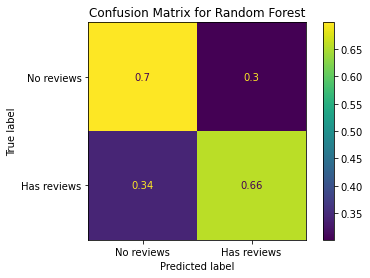

In [60]:
r_f = RandomForestClassifier(n_estimators = 100, max_depth = 6, class_weight = 'balanced', random_state = 42)

r_f.fit(X_train_np, y_train_np)

y_pred = evaluate_model(r_f, X_test_np, y_test_np, "Random Forest")

record_score(results_loc,
             "Random Forest", X_train_np.shape[1],
             False, False, y_pred, y_test)

#### Using XGBoost's `scale_pos_weight`

Using the scale_pos_weight parameter to adjust for imbalanced classes (see [this](https://machinelearningmastery.com/xgboost-for-imbalanced-classification/#:~:text=The%20XGBoost%20algorithm%20is%20effective,over%20the%20model%20training%20procedure.) blog post).


In [61]:
prop_no_reviews = sum(y_train==0)/sum(y_train==1)
prop_no_reviews

0.25634598299276556

F1 scores for  XGBoost :

F1 score of negative class: 	 0.47536945812807874 
Macro average F1 score: 	 0.6372761809810727


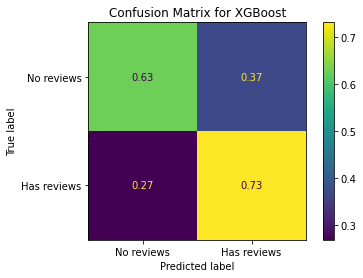

In [62]:
xgb_model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', scale_pos_weight = prop_no_reviews, seed = 42)

xgb_model.fit(X_train_np, y_train_np)

y_pred = evaluate_model(xgb_model, X_test_np, y_test_np, "XGBoost")

record_score(results_loc,
             "XGBoost", X_train_np.shape[1],
             False, False, y_pred, y_test_np)

### 2.3.3 Downsampling

In [63]:
# we will downsample only the training data.

def downsample(df: pd.DataFrame, target_col: str, majority_label: int) -> pd.DataFrame:
    """
    Given the label of the majority class in the target column of the dataframe,
    randomly remove observations where the target belongs to the majority class
    until the classes are of equal size. Return the balanced dataset.
    """
    minority_label = 1 if majority_label == 0 else 0
    # separate majority and minority class
    majority_class = df[df[target_col]== majority_label]
    minority_class = df[df[target_col]== minority_label]
    # count number of observations in minority class
    count_minority_class = len(minority_class.index)
    # downsample the majority class using sklearn's resample
    majority_class_downsampled = resample(majority_class, replace = False, n_samples = count_minority_class, random_state = 42)
    df_balanced = pd.concat([majority_class_downsampled, minority_class], axis = 0, sort = True)
    df_balanced.reset_index(drop=True)
    return df_balanced
    
# reattach target variable
proc_train['has_reviews'] = y_train

# Create a demonstration dataset to visualise the process
downsample_demo = proc_train.copy().reset_index()

# downsample the training dataset
train_ds = downsample(proc_train, 'has_reviews', 1)

print(train_ds["has_reviews"].value_counts())

# remove the target variable again.
y_train_ds = train_ds.pop('has_reviews')
X_train_ds = train_ds

0    8079
1    8079
Name: has_reviews, dtype: int64


In [64]:
# Make sure columns are still in same order
X_train_ds = X_train_ds[X_test.columns]
X_train_ds.columns

Index(['availability_frac', 'room_type_entire_home/apt',
       'room_type_private_room', 'scaled_minimum_nights',
       'scaled_calculated_host_listings_count', 'scaled_longitude',
       'scaled_latitude', 'scaled_log_price'],
      dtype='object')

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


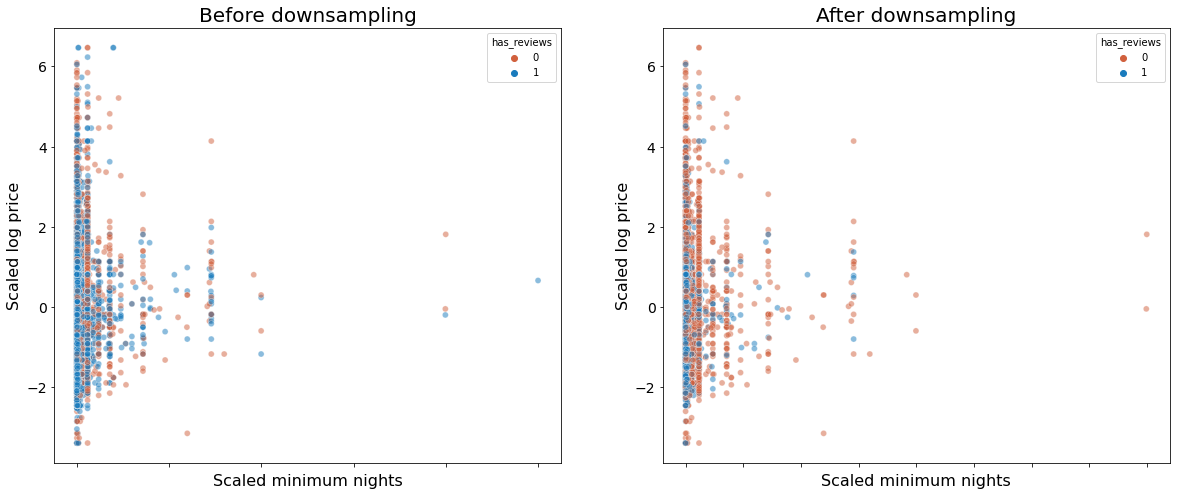

In [65]:
## visualise the downsampling

# create dataset of observations that remained in the downsampled dataframe
downsample_demo['in_downsampled_dataset'] = downsample_demo['index'].apply(lambda i: i in train_ds.index)

# label the observations as 'has reviews', 'no reviews', or 'removed from dataset'
categories = [
    (downsample_demo['has_reviews']==1) & (downsample_demo['in_downsampled_dataset']),
    (downsample_demo['has_reviews']==0) & (downsample_demo['in_downsampled_dataset']),
    (~downsample_demo['in_downsampled_dataset'])
]
category_labels = [
    'Has reviews', 'No reviews', 'Removed from dataset'
]
downsample_demo['category'] = np.select(categories, category_labels)

# draw before/after scatter plots
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20,8))
sns.scatterplot(data = downsample_demo,
                x = 'scaled_minimum_nights',
                y = 'scaled_log_price',
                hue = 'has_reviews',
                alpha = 0.5,
                palette = palette,
                ax = ax1)
ax1.set_title("Before downsampling", fontsize = 20)
ax1.set_xlabel("Scaled minimum nights", fontsize = 16)
ax1.set_ylabel("Scaled log price", fontsize = 16)
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize = 14)

sns.scatterplot(data = downsample_demo[downsample_demo['category']!='Removed from dataset'],
                x = 'scaled_minimum_nights',
                y = 'scaled_log_price',
                hue = 'has_reviews',
                alpha = 0.5,
                palette = palette,
                ax = ax2)

ax2.set_title("After downsampling", fontsize = 20)
ax2.set_xlabel("Scaled minimum nights", fontsize = 16)
ax2.set_ylabel("Scaled log price", fontsize = 16)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize = 14)

plt.draw()

ax1.set_yticklabels(ax1.get_yticklabels(), fontsize = 14)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize = 14);

#### Logistic Regression with Downsampling

F1 scores for  Logistic Regression :

F1 score of negative class: 	 0.380134428678118 
Macro average F1 score: 	 0.5544906053877359


feature      coef
3                  scaled_minimum_nights -9.775797
4  scaled_calculated_host_listings_count -3.059861
1              room_type_entire_home/apt  1.080192
0                      availability_frac  0.634487
2                 room_type_private_room  0.460691
7                       scaled_log_price -0.377558
6                        scaled_latitude -0.038771
5                       scaled_longitude  0.002803

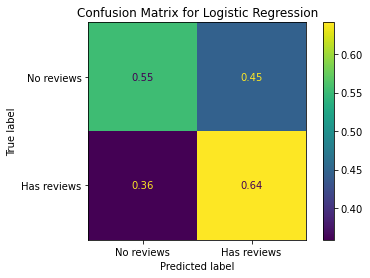

In [66]:
lr = LogisticRegression()

lr.fit(X_train_ds, y_train_ds)

y_pred = evaluate_model(lr, X_test, y_test, "Logistic Regression")

record_score(results_loc,
             "Logistic Regression", X_train_ds.shape[1],
             True, False, y_pred, y_test)

coefficients = pd.DataFrame(data = {
    'feature': X_train_ds.columns,
    'coef': lr.coef_[0],
    'coef_magnitude': [abs(c) for c in lr.coef_[0]]
})
coefficients.sort_values('coef_magnitude', ascending = False).drop(columns = ['coef_magnitude'])

The logistic regression model actually performs worse with downsampling than without. This is likely to be because the training dataset has been reduced in size.

In [67]:
print("Size of original dataset: ", len(X_train),
      "\nSize of downsampled dataset: ", len(X_train_ds),
     "\nSize of test dataset: ", len(X_test))

Size of original dataset:  39595 
Size of downsampled dataset:  16158 
Size of test dataset:  4400


Feature selection will be applied using SelectKBest to see if a reduced number of features improves the performance.

num_features  neg_class_f1
0             1      0.197874
1             2      0.283433
2             3      0.335104
3             4      0.332659
4             5      0.336808
5             6      0.368739
6             7      0.383167

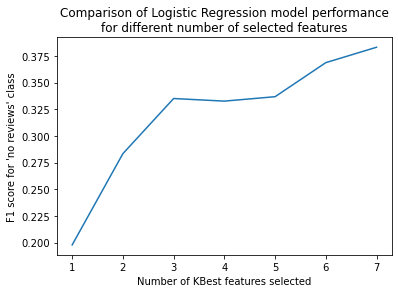

In [68]:
# Choose the best number of features

def feature_select(X_train: pd.DataFrame, 
                   y_train: pd.DataFrame, 
                   X_test: pd.DataFrame, 
                   y_test: pd.DataFrame, 
                   model, 
                   model_name: str) -> pd.DataFrame:
    """
    Repeatedly train the model on between 1 and all possible features, choosing the number of features
    using SelectKBest each time. Display model performance on each number of features.
    Return a dataframe of the model performance for each number of features.
    """
    num_features = range(1,len(X_train.columns))
    f1_scores = []
    for num in num_features:
        # select {num} best features
        kbest = SelectKBest(score_func = f_classif, k = num).fit(X=X_train, y = y_train)
        # get selected columns
        selected_columns = X_train.columns[kbest.get_support()]
        # fit model
        model.fit(X_train[selected_columns], y_train)
        y_pred = model.predict(X_test[selected_columns])
        # look specifically at the F1 score of the 'no reviews' class
        f1 = f1_score(y_test, y_pred, pos_label = 0)
        f1_scores.append(f1)
    # plot results
    ax = plt.plot(num_features, f1_scores)
    plt.ylabel("F1 score for 'no reviews' class")
    plt.xlabel("Number of KBest features selected")
    plt.title(f"Comparison of {model_name} model performance\nfor different number of selected features")
    return pd.DataFrame(data = {'num_features': num_features, 'neg_class_f1': f1_scores})
    
feature_select(X_train_ds, y_train_ds, X_test, y_test, LogisticRegression(), "Logistic Regression")

The model actually appears to perform the best with all of the features.

In [69]:
def get_coefficients(X_test: pd.DataFrame, model: LogisticRegression) -> pd.DataFrame:
    """
    Get the coefficients of a logistic regression model and return as a dataframe sorted by magnitude.
    """
    coefs = model.coef_[0]
    coefficients = pd.DataFrame(data = {
            'feature': X_test.columns,
            'coef': coefs,
            'coef_magnitude': [abs(c) for c in coefs]
        })

    return coefficients.sort_values('coef_magnitude', ascending = False).drop(columns = ['coef_magnitude'])

get_coefficients(X_test, lr)

feature      coef
3                  scaled_minimum_nights -9.775797
4  scaled_calculated_host_listings_count -3.059861
1              room_type_entire_home/apt  1.080192
0                      availability_frac  0.634487
2                 room_type_private_room  0.460691
7                       scaled_log_price -0.377558
6                        scaled_latitude -0.038771
5                       scaled_longitude  0.002803

Let's test our new downsampled dataset with a decision tree.

#### Decision Tree with Downsampling

F1 scores for  Decision Tree :

F1 score of negative class: 	 0.3994423143952597 
Macro average F1 score: 	 0.5544674057223306


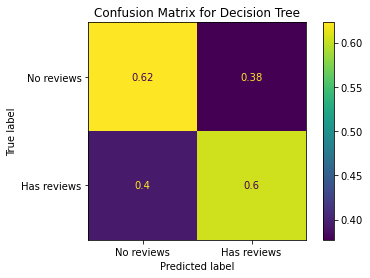

In [70]:
tree = DecisionTreeClassifier()

tree.fit(X_train_ds, y_train_ds)

y_pred = evaluate_model(tree, X_test, y_test, "Decision Tree")

record_score(results_loc,
             "Decision Tree", X_train_ds.shape[1],
             True, False, y_pred, y_test)

The decision tree definitely performs better with downsampling than without.

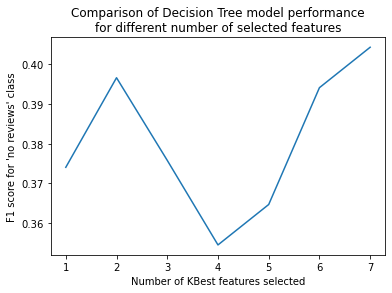

In [71]:
feature_select(X_train_ds, y_train_ds, X_test, y_test, tree, "Decision Tree");

F1 scores for  Decision Tree :

F1 score of negative class: 	 0.3966303966303966 
Macro average F1 score: 	 0.5538856906694244


'Selected features: scaled_minimum_nights, scaled_calculated_host_listings_count'

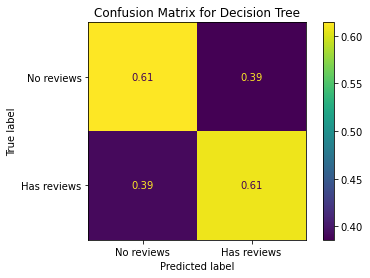

In [72]:
# Even though the model appears to perform best with 7 features, the peak at 2 features should be investigated.

def get_selected_columns(X_train: pd.DataFrame, y_train: pd.DataFrame, k:int):
    """
    Return the K best features for the given dataframe and K.
    """
    kbest = SelectKBest(score_func = f_classif, k = k)
    kbest.fit(X=X_train, y = y_train)
    cols = kbest.get_support()
    return X_train.columns[cols]

selected_features = get_selected_columns(X_train_ds, y_train_ds, 2)

tree.fit(X_train_ds[selected_features], y_train_ds)

y_pred = evaluate_model(tree, X_test[selected_features], y_test, "Decision Tree")

record_score(results_loc,
             "Decision Tree", len(selected_features),
             True, False, y_pred, y_test)

'Selected features: ' + ', '.join(selected_features)

#### Random Forest with Downsampling

F1 scores for  Random Forest :

F1 score of negative class: 	 0.4654804270462633 
Macro average F1 score: 	 0.607364587479726


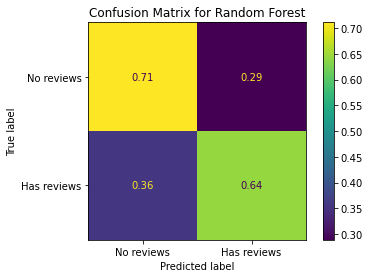

In [73]:
r_f = RandomForestClassifier(n_estimators = 100, max_depth = 6, class_weight = 'balanced')

r_f.fit(X_train_ds, y_train_ds)

y_pred = evaluate_model(r_f, X_test, y_test, "Random Forest")

record_score(results_loc,
             "Random Forest", X_train_ds.shape[1],
             True, False, y_pred, y_test)

There is a very slight improvement to the performance of the random forest model with downsampling.

#### XGBoost with downsampling

F1 scores for  XGBoost with downsampling :

F1 score of negative class: 	 0.4842951059167276 
Macro average F1 score: 	 0.6256843394974598


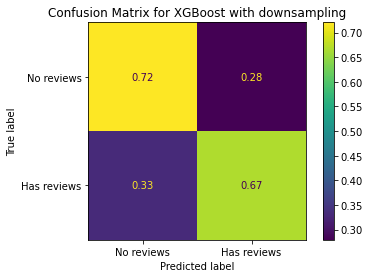

In [74]:
xgb_model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', seed = 42)

xgb_model.fit(X_train_ds, y_train_ds)

y_pred = evaluate_model(xgb_model, X_test, y_test, "XGBoost with downsampling")

record_score(results_loc,
             "XGBoost", X_train_ds.shape[1],
             True, False, y_pred, y_test)

num_features  neg_class_f1
0             1      0.374062
1             2      0.402235
2             3      0.419575
3             4      0.424197
4             5      0.416729
5             6      0.465884
6             7      0.475046

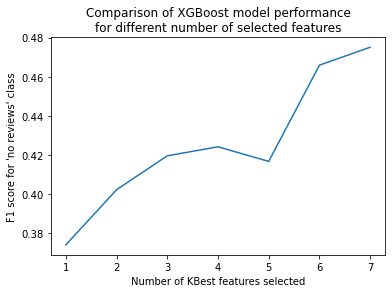

In [75]:
feature_select(X_train_ds, y_train_ds, X_test, y_test, xgb_model, "XGBoost")

### 2.3.4 Re-testing with outlier removal

All of the above models will be tested again without the outliers to see if it improves performance.

In [76]:
numeric_columns = X_train.select_dtypes('number').columns

# fit the outlier remover to the full (not downsampled) training set

o_r = OutlierRemover()
o_r.fit(proc_train[numeric_columns])

# remove the outliers from each of the downsampled and not downsampled training datasets.

X_train_ds_ol = pd.concat([X_train_ds, y_train_ds], axis = 1)
X_train_ol = pd.concat([X_train, y_train], axis = 1)

# Separate target variable in test dataset
X_train_ds_ol = o_r.transform(X_train_ds_ol)
X_train_ol = o_r.transform(X_train_ol)

y_train_ds_ol = X_train_ds_ol.pop('has_reviews')
y_train_ol = X_train_ol.pop('has_reviews')

print("Size of original dataset: ", len(X_train),
      "\nSize of dataset without outliers: ", len(X_train_ol),
      "\nSize of downsampled dataset: ", len(X_train_ds),
      "\nSize of downsampled dataset without outliers: ", len(X_train_ds_ol),
     "\n\nSize of test dataset: ", len(X_test),
     "\n\nProportion of listings with reviews in downsampled training dataset: ", len(y_train_ds_ol[y_train_ds_ol==1])/len(y_train_ds_ol[y_train_ds_ol==0]),
     "\n\nProportion of listings with reviews in training dataset: ", len(y_train_ol[y_train_ol==1])/len(y_train_ol[y_train_ol==0]),)

Size of original dataset:  39595 
Size of dataset without outliers:  37473 
Size of downsampled dataset:  16158 
Size of downsampled dataset without outliers:  15052 

Size of test dataset:  4400 

Proportion of listings with reviews in downsampled training dataset:  1.0568461328231757 

Proportion of listings with reviews in training dataset:  4.1206613828915


In [77]:
sum(y_test==0)/sum(y_test==1)

0.26436781609195403

In [78]:
downsampled = False

for model, model_name in zip([lr, tree, xgb_model, r_f], ['Logistic Regression', 'Decision Tree', 'XGBoost', 'Random Forest']):
    for training_set in [(X_train_ol, y_train_ol), (X_train_ds_ol, y_train_ds_ol)]:
        if model_name == 'XGBoost':
            if downsampled:
                model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss',seed = 42)
            else:
                train = training_set[1]
                prop_no_reviews = sum(train==0)/sum(train==1)
                model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss',seed = 42, scale_pos_weight = prop_no_reviews)
        model.fit(training_set[0], training_set[1])
        y_pred = model.predict(X_test)
        record_score(results_loc,
                 model_name, training_set[0].shape[1],
                 downsampled, True, y_pred, y_test)
        downsampled = not downsampled

###  2.3.5 Model Selection

The results of all of the above models will be compared in order to select the best performing model by its F1 score.

In [79]:
all_models = pd.read_csv(results_loc).drop_duplicates() # in case cell was run twice
all_models.sort_values('f1_negative_class', ascending = False)

model_name  number_of_features downsampled_data outliers_removed  \
8               XGBoost                   8                y                n   
13              XGBoost                   8                n                y   
3               XGBoost                   8                n                n   
14              XGBoost                   8                y                y   
2         Random Forest                   8                n                n   
15        Random Forest                   8                n                y   
7         Random Forest                   8                y                n   
16        Random Forest                   8                y                y   
12        Decision Tree                   8                y                y   
5         Decision Tree                   8                y                n   
6         Decision Tree                   2                y                n   
0   Logistic Regression                   8                n                n   
10  Logistic Regression                   8                y                y   
4   Logistic Regression                   8                y                n   
1         Decision Tree                   8                n                n   
11        Decision Tree                   8                n                y   
9   Logistic Regression                   8                n                y   

    f1_negative_class  f1_macro_average  
8            0.484295          0.625684  
13           0.476721          0.633780  
3            0.475369          0.637276  
14           0.474466          0.617097  
2            0.466788          0.611888  
15           0.466713          0.605371  
7            0.465480          0.607365  
16           0.462788          0.595528  
12           0.407305          0.557841  
5            0.399442          0.554467  
6            0.396630          0.553886  
0            0.386834          0.557426  
10           0.380665          0.557042  
4            0.380134          0.554491  
1            0.365904          0.594238  
11           0.336573          0.573546  
9            0.103516          0.492730

FixedFormatter should only be used together with FixedLocator


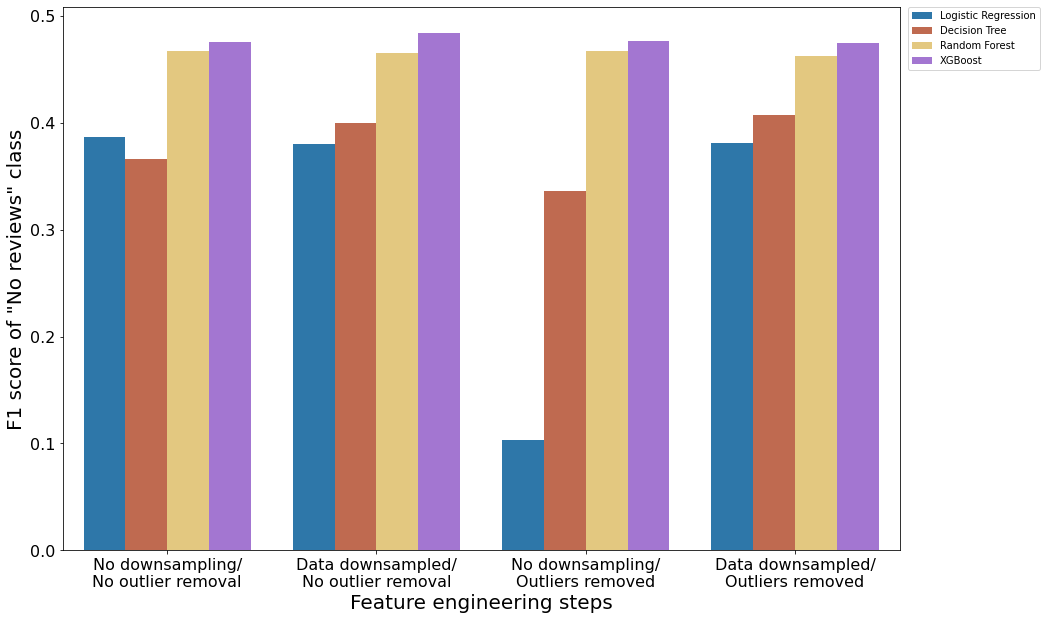

In [80]:
all_models['feature_engineering_steps'] = (all_models['downsampled_data']+all_models['outliers_removed']).map(
    {'nn': 'No downsampling/\nNo outlier removal',
     'ny': 'No downsampling/\nOutliers removed',
     'yn': 'Data downsampled/\nNo outlier removal',
     'yy': 'Data downsampled/\nOutliers removed'}
)

model_palette = {
    m: c for m, c in zip(all_models['model_name'].unique().tolist(), ['#197BBD', '#D1603D', '#F4D06F', '#A367E0'])
}

fig, ax = plt.subplots(figsize = (15,10))
sns.barplot(data = all_models[all_models['number_of_features']==8],
            x = 'feature_engineering_steps', y = 'f1_negative_class', hue = 'model_name',
            palette = model_palette);
ax.set_xlabel('Feature engineering steps', fontsize = 20)
ax.set_ylabel('F1 score of "No reviews" class', fontsize = 20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 16)
plt.draw()
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 16)
ax.legend(fontsize = 15)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0);

Whilst the random forest model was the most consistent in performance, the XGBoost model performed the best in three out of the four groups, the best-performing model was the XGBoost, and the F1 score for the no reviews class was particularly high when dataset was downsampled.

*NB This is a slightly different result to that reported in my presentation; I have made some improvements to the downsampling mechanism*

F1 scores for  XGBoost :

F1 score of negative class: 	 0.4842951059167276 
Macro average F1 score: 	 0.6256843394974598


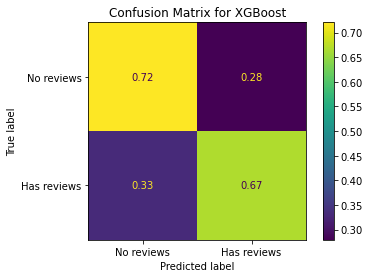

In [81]:
best_xgb_model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss',seed = 42)

best_xgb_model.fit(X_train_ds, y_train_ds)

y_pred = evaluate_model(best_xgb_model, X_test, y_test, "XGBoost");


This model performs better than all of the previous models. We will briefly explore the results of this model before tuning. In particular, its performance on listings with availability = 0 should be examined.

In [82]:
def categorise_variable(x: float) -> float:
    """
    Bin the variable into tens
    """
    return math.floor(x*10)/10 if x <1 else 0.9

def get_predictions_by_availability(X: pd.DataFrame, y_test: pd.DataFrame, y_pred: np.ndarray) -> pd.DataFrame():
    """
    Returns a dataframe in which the number of listings that have reviews and number predicted to have reviews
    are counted for each "category" of availability (0-10%, 10-20%, etc.)
    The resulting dataframe is tidy i.e. one observation per row.
    """
    # make a copy of the test set
    results = X.copy()
    results['y'] = y_test
    results['y_pred'] = y_pred

    # Bin the availability column into categories
    results['availability_cat'] = results['availability_frac'].apply(categorise_variable)

    # Count number of listings that HAVE reviews
    has_reviews = pd.DataFrame(results[results['y']==1].groupby('availability_cat')['y'].count())
    has_reviews['value'] = 'true'

    # Count number of listings that are PREDICTED TO have reviews
    predicted_reviews = pd.DataFrame(results[results['y_pred']==1].groupby('availability_cat')['y'].count())
    predicted_reviews['value'] = 'predicted'

    # Combine the two dataframes by stacking.
    availability_reviews = pd.concat([has_reviews, predicted_reviews], axis = 0)
    availability_reviews.columns= ['count', 'value']
    availability_reviews.reset_index(inplace = True, drop = False)
    return availability_reviews

availability_reviews = get_predictions_by_availability(X_test, y_test, y_pred)
availability_reviews

availability_cat  count      value
0                0.0   1609       true
1                0.1    251       true
2                0.2    264       true
3                0.3    124       true
4                0.4    211       true
5                0.5    127       true
6                0.6    146       true
7                0.7    171       true
8                0.8    168       true
9                0.9    409       true
10               0.0    998  predicted
11               0.1    216  predicted
12               0.2    229  predicted
13               0.3    123  predicted
14               0.4    176  predicted
15               0.5    113  predicted
16               0.6    127  predicted
17               0.7    164  predicted
18               0.8    143  predicted
19               0.9    293  predicted

FixedFormatter should only be used together with FixedLocator


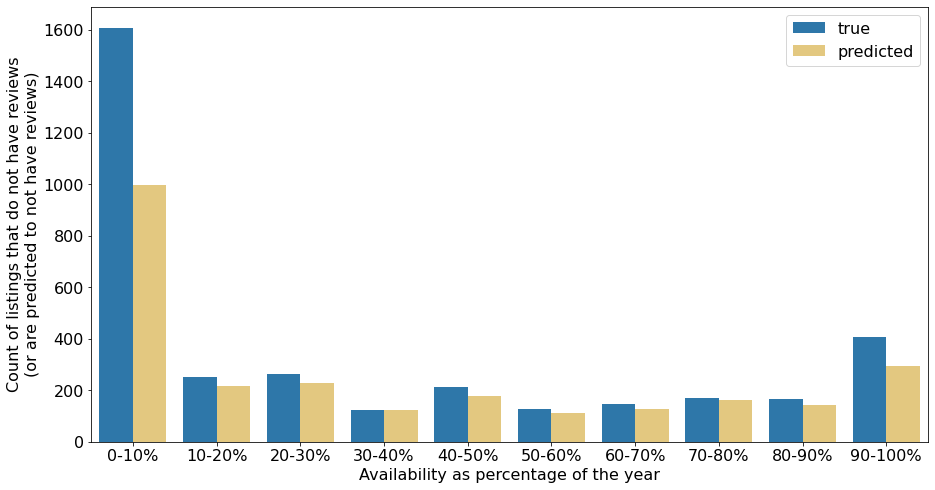

In [83]:
def plot_availability_reviews(availability_reviews: pd.DataFrame, color = 'black'):
    """
    Plot the number of listings that have reviews and number predicted to have reviews against availability category.
    """
    avail_palette = {
        'true': '#197BBD',
        'predicted': '#F4D06F'
    }

    fig, ax = plt.subplots(figsize = (15,8))

    sns.barplot(data = availability_reviews, x = 'availability_cat', y = 'count', hue = 'value', palette = avail_palette)
    ax.set_xticklabels([
        '0-10%', '10-20%', '20-30%', '30-40%', 
        '40-50%', '50-60%', '60-70%', '70-80%', 
        '80-90%', '90-100%'
    ], 
        rotation = 0, fontsize = 16,
        color = color
    )

    ax.set_xlabel(
        "Availability as percentage of the year", 
        fontsize = 16, 
        color = color
    )
    ax.set_ylabel(
        "Count of listings that do not have reviews\n(or are predicted to not have reviews)",
        fontsize = 16, 
        color = color
    )
    #ax.set_title("Comparison of true and predicted values of 'has reviews' for NYC listings\nby availability of the listing.")
    plt.draw()

    ax.set_yticklabels(ax.get_yticklabels(), color = color, fontsize = 16)
    ax.legend(fontsize = 16);
    
plot_availability_reviews(availability_reviews, color = 'black')

As suspected from the beginning, the model performs worse on low availability listings than on higher availability listings. It is under-predicting the number of listings that have reviews. However, we know that a listing with availability 0 should have no reviews, and if a listing with availability = 0 *does* have reviews, these would have been placed at a time when the availability was higher.

For this reason, we will try the above models again after removing al listings with availability = 0.

In [84]:
def remove_unavailable_listings(X: pd.DataFrame, y: pd.DataFrame)-> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Remove all listings that do not have availability from the X dataset and corresponding y dataset.
    """
    X_new = X[X['availability_frac']>0]
    available_index = X_new.index
    y_new = y.iloc[available_index]
    return X_new, y_new

# Remove unavailable listings
X_train_available, y_train_available = remove_unavailable_listings(X_train, y_train)
X_test_available, y_test_available = remove_unavailable_listings(X_test, y_test)

# also get a downsampled dataset

# reattach target variable
X_train_available['has_reviews'] = y_train_available

# downsample the training dataset
train_ds_available = downsample(X_train_available, 'has_reviews', 1)

print(train_ds_available['has_reviews'].value_counts())

# remove the target variable again.
y_train_ds_available = train_ds_available.pop('has_reviews')
X_train_ds_available = train_ds_available

X_train_available = X_train_available.drop(['has_reviews'], axis = 1)

# make sure all column names match

X_train_available = X_train_available[X_train.columns]
X_test_available = X_test_available[X_train.columns]
X_train_ds_available = X_train_ds_available[X_train.columns]

0    4208
1    4208
Name: has_reviews, dtype: int64



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [85]:
prop_no_reviews = sum(y_train_available==0)/sum(y_train_available==1)
prop_no_reviews

0.19806081144686058

FixedFormatter should only be used together with FixedLocator


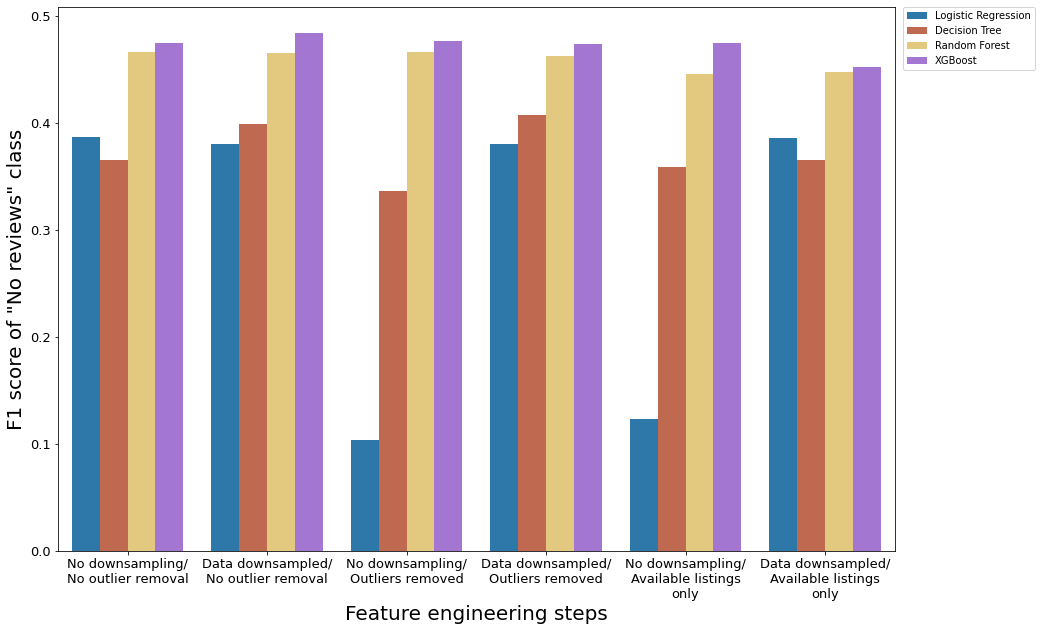

In [86]:
downsampled = False

# iterate through two new sets of training/testing data, train each model and record results.
for model, model_name in zip([lr, tree, xgb_model, r_f], ['Logistic Regression', 'Decision Tree', 'XGBoost', 'Random Forest']):
    for training_set in [(X_train_available, y_train_available), (X_train_ds_available, y_train_ds_available)]:
        # ensure scale_pos_weight is set when data is not downsampled
        if model_name == 'XGBoost':
            if not downsampled:
                model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss',seed = 42, 
                                      scale_pos_weight = prop_no_reviews)
            else:
                model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss',seed = 42)
        # fit model
        model.fit(training_set[0], training_set[1])
        y_pred = model.predict(X_test_available)
        # evaluate
        f1_0, f1_avg = calculate_f1s(y_pred, y_test_available)
        if downsampled:
            feature_eng_steps = 'Data downsampled/\n'
        else:
            feature_eng_steps = 'No downsampling/\n'
        feature_eng_steps += 'Available listings\nonly'
        downsampled_data = 'y' if downsampled else 'n'
        # add to existing dataframe.
        all_models = all_models.append(dict(
            model_name = model_name,
            number_of_features = 8,
            downsampled_data = downsampled,
            outliers_removed = 'y',
            f1_negative_class = f1_0,
            f1_macro_average = f1_avg,
            feature_engineering_steps = feature_eng_steps
        ), ignore_index = True)
        downsampled = not downsampled
 
# Plot the results
fontcolor = 'black' # change to white when need to copy resulting image to dark background
fig, ax = plt.subplots(figsize = (15,10))
sns.barplot(data = all_models[all_models['number_of_features']==8],
            x = 'feature_engineering_steps', y = 'f1_negative_class', hue = 'model_name',
            palette = model_palette);
ax.set_xlabel('Feature engineering steps', fontsize = 20, color = fontcolor)
ax.set_ylabel('F1 score of "No reviews" class', fontsize = 20, color = fontcolor)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 13, color = fontcolor)
plt.draw()
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 13, color = fontcolor)
ax.legend(fontsize = 15)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0);

In [87]:
all_models.drop_duplicates().sort_values('f1_negative_class', ascending = False).head(1)

model_name  number_of_features downsampled_data outliers_removed  \
8    XGBoost                   8                y                n   

   f1_negative_class  f1_macro_average              feature_engineering_steps  
8           0.484295          0.625684  Data downsampled/\nNo outlier removal

The top performing model has not changed.

F1 scores for  XGBoost :

F1 score of negative class: 	 0.4746666666666667 
Macro average F1 score: 	 0.6705536723163842


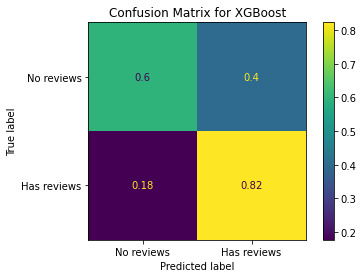

In [88]:
available_xgb_model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss',seed = 42, scale_pos_weight = prop_no_reviews)

available_xgb_model.fit(X_train_available, y_train_available)

y_pred = evaluate_model(available_xgb_model, X_test_available, y_test_available, "XGBoost");

FixedFormatter should only be used together with FixedLocator


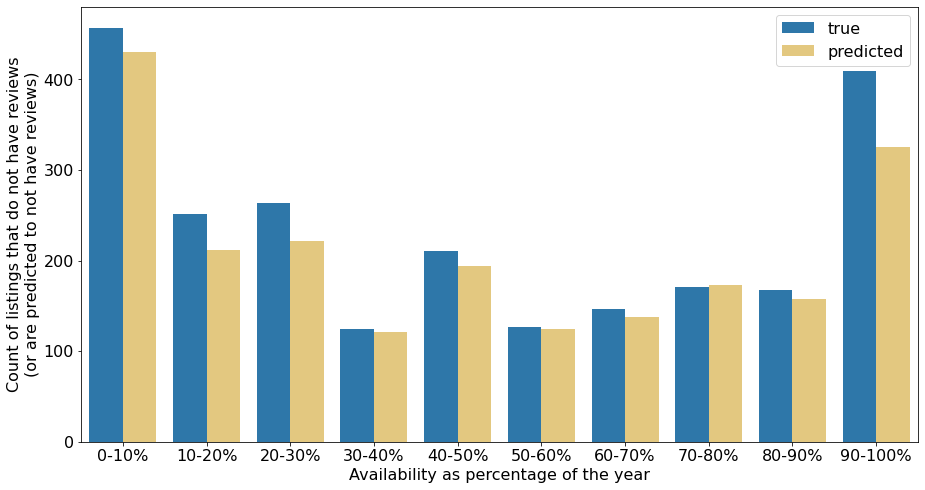

In [89]:
plot_availability_reviews(get_predictions_by_availability(X_test_available, y_test_available, y_pred))

This model has much better accuracy and performs better on the listings that have availability < 10% (because there are no listings with availability =0). To meaningfully compare this model to the previous best model, however, we should test the previous best model on a test set without unavailable listings (`X_test_available`).

F1 scores for  XGBoost :

F1 score of negative class: 	 0.48841059602649006 
Macro average F1 score: 	 0.6730399364287218


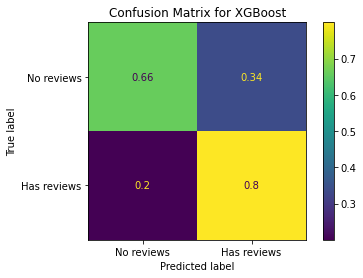

In [90]:
y_pred = evaluate_model(best_xgb_model, X_test_available, y_test_available, "XGBoost");

FixedFormatter should only be used together with FixedLocator


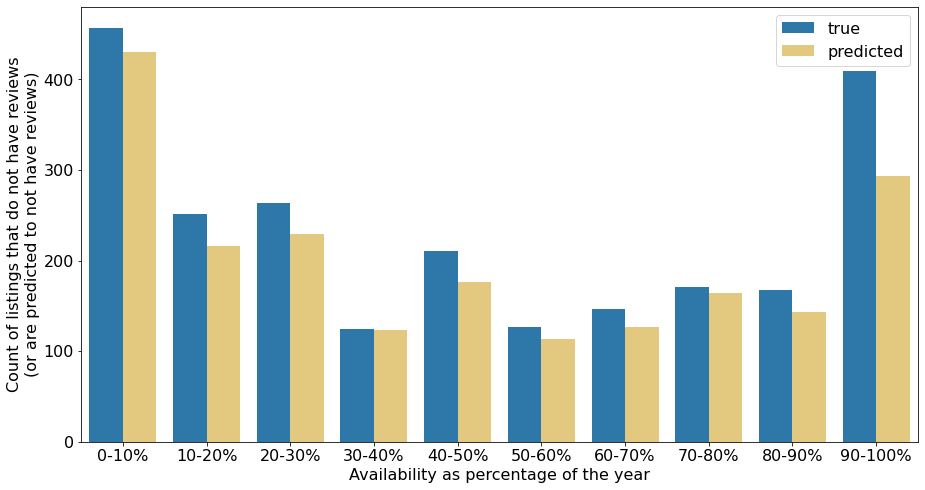

In [91]:
plot_availability_reviews(get_predictions_by_availability(X_test_available, y_test_available, y_pred))

This is the best performing model of the two; despite having a slightly lower recall than previously (when the test set included listings with availability of 0), it misidentifies far fewer listings that have reviews.

It would be entirely reasonable to suggest to Airbnb that this model should not be used to make predictions on listings that are currently listed with availability = 0, so this is what we shall do for tuning and evaluating the model.

###  2.3.6 Model Tuning

To improve the model the hyperparameters will be tuned. For this, the training and validation data shall be combined and the final test set used.

In [92]:
all_training_data = pd.concat([raw_train, raw_test])

# downsample the training dataset
all_training_data = downsample(all_training_data, 'has_reviews', 1)

# separate target variable
y_train_all = all_training_data['has_reviews']

# Fit the transformers to the training dataset
X_train_all = apply_transformations(
    all_training_data.drop(columns = ['neighbourhood_group', 'neighbourhood', 'has_reviews']),
    one_hot_encoder, minmax_scaler, standard_scaler, fit = True
)

# prepare the final test set
final_test_set = encode_target(final_test_set)

final_test_set = final_test_set[final_test_set['availability_365']>0]

y_test_final = final_test_set.pop('has_reviews')

X_test_final = apply_transformations(
    final_test_set.drop(['neighbourhood', 'neighbourhood_group'], axis = 1), 
    one_hot_encoder, minmax_scaler, standard_scaler, fit = False
)

X_test_final.shape

(3125, 8)

F1 scores for  Optimised XGBoost Model :

F1 score of negative class: 	 0.42784810126582284 
Macro average F1 score: 	 0.6171360420676009


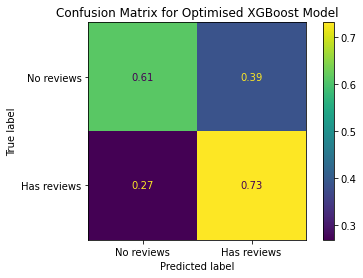

In [93]:
# Warning! GridSearchCV in use, this cell takes a long time to run!

params = {
    'max_depth': [2,4,6,8],
    'learning_rate': [0.1,0.2,0.4,0.8],
    'objective': ['reg:squarederror', 'binary:logistic'],
    'tree_method': ['exact', 'hist']
}

custom_scorer = make_scorer(f1_score, pos_label = 0)

xgb_optimised = GridSearchCV(best_xgb_model, params, scoring = custom_scorer).fit(X_train_all, y_train_all)

evaluate_model(xgb_optimised, X_test_final, y_test_final, "Optimised XGBoost Model");

There is a slight reduction in F1 score but it is difficult to compare because we are testing on a different set.

In [94]:
model_parameters = xgb_optimised.best_params_
model_parameters

{'learning_rate': 0.2,
 'max_depth': 4,
 'objective': 'binary:logistic',
 'tree_method': 'exact'}

In [95]:
# fit the model using the best parameters.

model = XGBClassifier(
    use_label_encoder = False, 
    eval_metric = 'logloss', 
    seed = 42,
    tree_method = 'hist'
)
model.set_params(**xgb_optimised.best_params_)
model.fit(X_train_all, y_train_all);

y_pred = model.predict(X_test_final)

## 2.4 Exploring Results

### 2.4.1 Feature Importance



Even though the logistic regression model was not selected, the coefficients of the best performing logistic regression model should be examined.

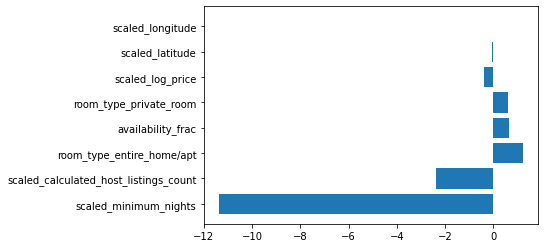

In [96]:
lr.fit(X_train_np, y_train_np)
lr_coefs = get_coefficients(X_test, lr)

fig, ax = plt.subplots()
ax.barh(y = lr_coefs['feature'], width = lr_coefs['coef']);

This suggests that:

- higher minimum nights, higher host listings count, and higher price lead to lower likelihood of reviews
- higher availability leads to greater likelihood of reviews
- both private rooms and entire apartments lead to greater likelihood of reviews

The third point suggests that shared rooms are less likely to be reviewed (by implication; a listing is a shared room if it is neither of the others). Location appears to have little to no impact on review chances.

To assess the feature importances of the XGBoost model, SHAP values will be used. SHAP values quantify the relative contribution of each feature to a model's predictions (Lundberg, 2018).

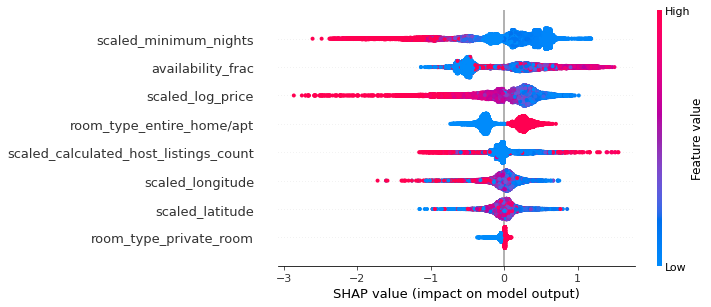

In [97]:
shap_values = shap.TreeExplainer(model).shap_values(X_train_all) 
shap.summary_plot(shap_values, X_train_all)

In [98]:
# in order to better understand the variables, the scaled data should be transformed back.
X_train_all[['minimum_nights', 'calculated_host_listings_count']] = minmax_scaler.inverse_transform(X_train_all[['scaled_minimum_nights', 'scaled_calculated_host_listings_count']])
X_train_all[['longitude', 'latitude', 'log_price']] = standard_scaler.inverse_transform(X_train_all[['scaled_longitude', 'scaled_latitude', 'scaled_log_price']])
X_train_all['price'] = [x+1 for x in np.exp(X_train_all['log_price'])]
X_train_all.head()

availability_frac  room_type_entire_home/apt  room_type_private_room  \
0           0.649315                        0.0                     1.0   
1           0.147945                        0.0                     1.0   
2           0.000000                        1.0                     0.0   
3           0.000000                        1.0                     0.0   
4           0.860274                        1.0                     0.0   

   scaled_minimum_nights  scaled_calculated_host_listings_count  \
0               0.029029                               0.312883   
1               0.001001                               0.000000   
2               0.001001                               0.000000   
3               0.003003                               0.000000   
4               0.000000                               0.000000   

   scaled_longitude  scaled_latitude  scaled_log_price  minimum_nights  \
0          0.242306         1.501463         -1.096509       11.566567   
1          0.708028        -0.558445         -1.444765        1.364364   
2         -0.430184        -0.725996          0.278115        1.364364   
3         -0.551294        -0.086931          0.452272        2.093093   
4          0.503463         1.247728          0.606593        1.000000   

   calculated_host_listings_count  longitude   latitude  log_price       price  
0                           103.0 -73.935303  40.810498   3.977987   54.409435  
1                             1.0 -73.910889  40.696329   3.724774   42.461881  
2                             1.0 -73.970558  40.687043   4.977460  146.105317  
3                             1.0 -73.976907  40.722463   5.104087  165.693673  
4                             1.0 -73.921613  40.796435   5.216292  185.249739

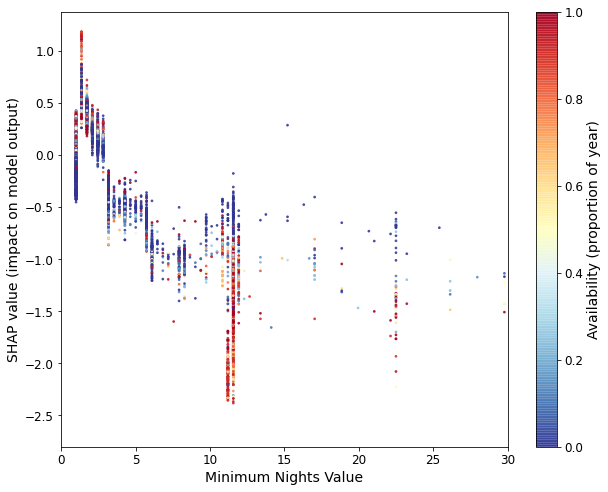

In [99]:
def plot_shap_values(x: pd.Series, shap: np.ndarray, c_values: pd.Series, 
                     clabel: str, xlabel: str, fontcolor = 'black', figsize = (10,8)):
    """
    Plot the given x values against the given shap values. Colour plot points by the given c_values.
    Return the axes of the plot for further customisation.
    """
    fig, ax = plt.subplots(figsize = figsize)
    # plot scatter diagram
    plt.scatter(x = x, y = shap, c = c_values, cmap = 'RdYlBu_r', s = 3, alpha = 0.8)
    # add colorbar
    cb = plt.colorbar()
    # label colorbar
    cb.set_label(clabel, color = fontcolor, fontsize = 14)
    # label axes
    ax.set_xlabel(xlabel, color = fontcolor, fontsize = 14)
    ax.set_ylabel('SHAP value (impact on model output)', color = fontcolor, fontsize = 14)
    plt.draw()
    # redraw ticks with given font color
    cb.ax.tick_params(color = fontcolor, labelcolor = fontcolor, labelsize = 12)
    ax.tick_params(color = fontcolor, labelcolor = fontcolor, labelsize = 12)
    return ax;
    
ax = plot_shap_values(X_train_all['minimum_nights'], shap_values[:, 3], X_train_all['availability_frac'], 
                 'Availability (proportion of year)', 'Minimum Nights Value', fontcolor = 'black')
ax.set_xlim(0,30);

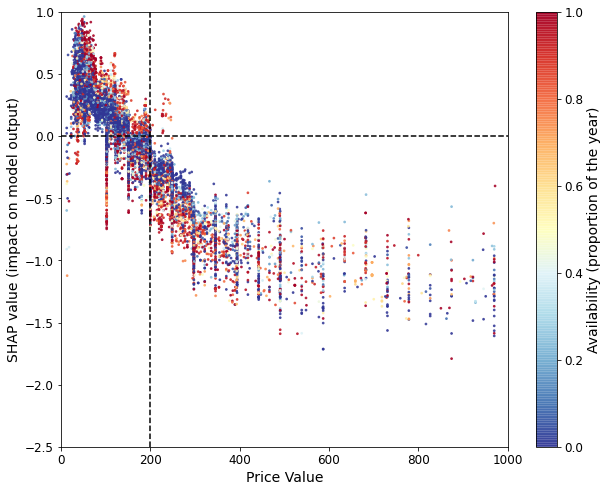

In [100]:
ax = plot_shap_values(X_train_all['price'], shap_values[:,7], X_train_all['availability_frac'], 
                 'Availability (proportion of the year)', 'Price Value', fontcolor='black')

ax.set_xlim(0,1000)
ax.set_ylim(-2.5, 1)
plt.hlines(0, xmin = 0, xmax = 1000, color = 'black', linestyle = '--')
plt.vlines(200, ymin = -2.5, ymax = 1, color = 'black', linestyle = '--');

Above ~ $200, price has a negative impact on the model's prediction, meaning that listings above this price are less likely to have reviews. Within this group, low availability listings are more likely to have reviews than high availability listings, which is a surprising find.

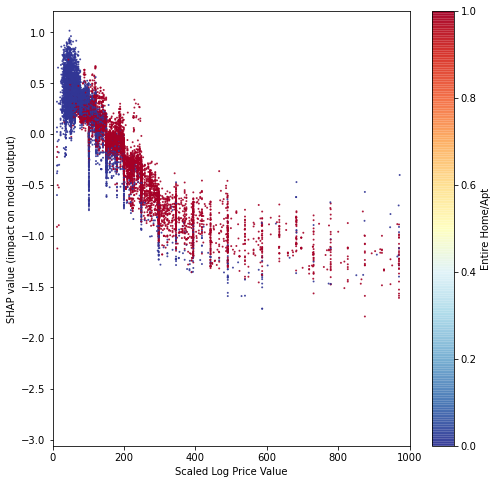

In [101]:


fig, ax = plt.subplots(figsize = (8,8))
# plot log_x_price against its SHAP values
plt.scatter(x = X_train_all['price'], y = shap_values[:,7 ], c = X_train_all.iloc[:, 1], cmap = 'RdYlBu_r', s =1, alpha = 0.8)
plt.colorbar(label = 'Entire Home/Apt')
ax.set_xlabel('Scaled Log Price Value')
ax.set_ylabel('SHAP value (impact on model output)')
ax.set_xlim(0,1000);

Listings that offer an entire home/apartment are generally a higher price, and of these the higher the price, the greater the negative impact on the model, making it less likely to predict that a given listing will have reviews.
Almost all of the other listings have very little impact on the model output.

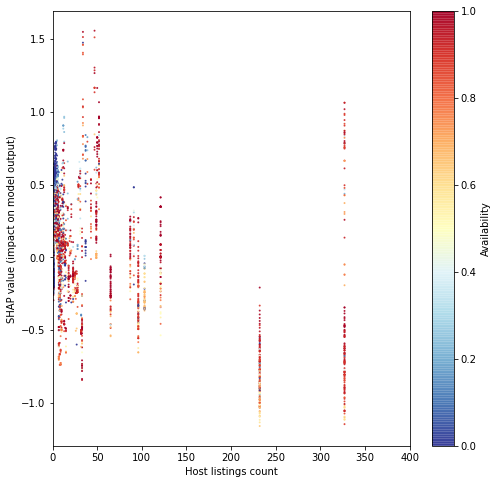

In [102]:
fig, ax = plt.subplots(figsize = (8,8))
# plot log_x_price against its SHAP values
plt.scatter(x = X_train_all['calculated_host_listings_count'], y = shap_values[:,4 ], c = X_train_all['availability_frac'], cmap = 'RdYlBu_r', s =1, alpha = 0.8)
plt.colorbar(label = 'Availability')
ax.set_xlabel('Host listings count')
ax.set_ylabel('SHAP value (impact on model output)')
ax.set_xlim(0,400);

Each of the vertical columns of dots is a different host, who has (for example) 100, 230, or 325 listings. Each dot within that vertical column is a listing belonging to that host.
There are two findings here:

1. Listings belonging to hosts with a high number of listings tend to have greater availability (it can be assumed that the host does not live in any of them!)
2. For a given value of host listing count there is great variance in its effect on the model output.

The greatest variance is seen in the lowest and highest values of host listings count, whereas the groups in the middle are somewhat more tightly-packed implying the model has grouped them together in other ways.

### 2.4.2 Predictions

The model's predictions will be visualised to identify patterns among the features of listings that are predicted not to have reviews.

In [103]:
# for visualising performance, the final test set will be used.
results = final_test_set.reset_index(drop = True).copy()

results_processed = apply_transformations(
    results.drop([
        'neighbourhood_group', 'neighbourhood'
    ], axis = 1),
    one_hot_encoder, minmax_scaler, standard_scaler, fit = False
)

results['y'] = y_test_final.reset_index(drop = True)
results['y_pred'] = model.predict(results_processed)
results = convert_availability_column(results)
results.head()

neighbourhood_group              neighbourhood  latitude  longitude  \
0           Manhattan                    Chelsea  40.73778  -73.99616   
1           Manhattan                East Harlem  40.79142  -73.94664   
2            Brooklyn               Williamsburg  40.71906  -73.94394   
3           Manhattan                     Harlem  40.81249  -73.94175   
4            Brooklyn  Prospect-Lefferts Gardens  40.65926  -73.96252   

         room_type  price  minimum_nights  calculated_host_listings_count  y  \
0     Private room     99              12                               4  1   
1     Private room     90               2                               4  1   
2  Entire home/apt     80              30                               8  1   
3     Private room     90               4                               2  0   
4     Private room    100               3                               1  1   

   y_pred  availability_frac  
0       0           0.079452  
1       1           0.649315  
2       1           0.265753  
3       1           1.000000  
4       0           0.997260

In [104]:
# for visualising predictions the entire dataset will be used.
results_all = pd.read_csv(path_to_dataset).drop(['last_review', 'reviews_per_month', 'name', 'host_name', 'id'], axis = 1)
results_all = encode_target(results_all)
# Only examine available listings!
results_all = results_all[results_all['availability_365']>0]
results_all.rename(columns = {'has_reviews': 'y'}, inplace = True)
for_prediction = apply_transformations(
    results_all.drop(['host_id', 'neighbourhood_group', 'neighbourhood', 'y'], axis = 1),
    one_hot_encoder, minmax_scaler, standard_scaler
)
results_all['y_pred'] = model.predict(for_prediction)

In [105]:
def grouped_f1_scores(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Group the dataframe by the given column and calculate the model's F1 score for each group.
    Return dataframe of group, group size, proportion without reviews, and F1 score
    """
    groups = df[column].unique()
    f1_scores = []
    num_listings = []
    no_reviews_prop = []
    for group in groups:
        temp = df[df[column]==group]
        f1_scores.append(round(f1_score(temp['y'], temp['y_pred'], pos_label = 0, zero_division = 0),2))
        group_size = len(temp)
        num_listings.append(group_size)
        no_reviews_prop.append(len(temp[temp['y']==0])/group_size)
    return pd.DataFrame(data = {
        column: groups,
        'f1_score': f1_scores,
        'size_of_group': num_listings,
        'prop_without_reviews': no_reviews_prop
    }).sort_values('f1_score', ascending = False).reset_index(drop = True)

f1_scores_room_type = grouped_f1_scores(results, 'room_type')
f1_scores_room_type

room_type  f1_score  size_of_group  prop_without_reviews
0      Shared room      0.48             83              0.216867
1  Entire home/apt      0.44           1627              0.185003
2     Private room      0.41           1415              0.164664

The model performs approximately equally well on all room types.

In [106]:
f1_scores_neighbourhood_group = grouped_f1_scores(results, 'neighbourhood_group')
f1_scores_neighbourhood_group

neighbourhood_group  f1_score  size_of_group  prop_without_reviews
0           Manhattan      0.49           1292              0.208978
1               Bronx      0.40             95              0.115789
2              Queens      0.40            458              0.176856
3            Brooklyn      0.35           1242              0.150564
4       Staten Island      0.24             38              0.078947

There is more variance in model performance on neighbourhood groups. The model performs best in Manhattan, which has the highest proportion of listings without reviews, and worst in Staten Island, which has the lowest proportion of listings without reviews.

In [107]:
def evaluate_predictions(df: pd.DataFrame) -> pd.DataFrame:
    """
    Label values in the given dataframes as true positives, true negatives, false positives and false negatives.
    """
    # filter true positives
    true_positives = df.copy()[(df['y']==1) & (df['y_pred']==1)]
    true_positives['result'] = 'true_pos'
    # filter true negatives
    true_negatives = df.copy()[(df['y']==0) & (df['y_pred']==0)]
    true_negatives['result'] = 'true_neg'
    # filter false positives
    false_positives = df.copy()[(df['y']==0) & (df['y_pred']==1)]
    false_positives['result'] = 'false_pos'
    # filter false negatives
    false_negatives = df.copy()[(df['y']==1) & (df['y_pred']==0)]
    false_negatives['result'] = 'false_neg'
    # put the dataframes back together
    new_df = pd.concat([true_positives, true_negatives, false_positives, false_negatives], axis = 0).sort_index()
    return new_df
    
results_evaluated = evaluate_predictions(results)
results_evaluated.head()

neighbourhood_group              neighbourhood  latitude  longitude  \
0           Manhattan                    Chelsea  40.73778  -73.99616   
1           Manhattan                East Harlem  40.79142  -73.94664   
2            Brooklyn               Williamsburg  40.71906  -73.94394   
3           Manhattan                     Harlem  40.81249  -73.94175   
4            Brooklyn  Prospect-Lefferts Gardens  40.65926  -73.96252   

         room_type  price  minimum_nights  calculated_host_listings_count  y  \
0     Private room     99              12                               4  1   
1     Private room     90               2                               4  1   
2  Entire home/apt     80              30                               8  1   
3     Private room     90               4                               2  0   
4     Private room    100               3                               1  1   

   y_pred  availability_frac     result  
0       0           0.079452  false_neg  
1       1           0.649315   true_pos  
2       1           0.265753   true_pos  
3       1           1.000000  false_pos  
4       0           0.997260  false_neg

In [108]:
results_evaluated.groupby('result').count().iloc[:,0]

result
false_neg     690
false_pos     214
true_neg      338
true_pos     1883
Name: neighbourhood_group, dtype: int64

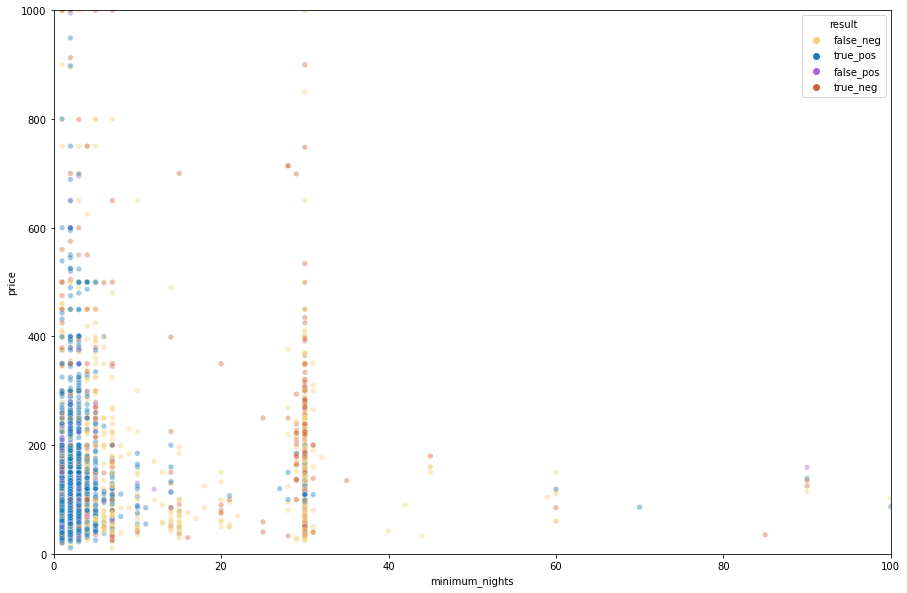

In [109]:
palette = {
    'true_pos': '#197BBD', 
    'false_pos': '#A367E0', 
    'false_neg': '#F4D06F', 
    'true_neg': '#D1603D'
}

fig, ax = plt.subplots(figsize = (15,10))

sns.scatterplot(data = results_evaluated,
                    x = 'minimum_nights',
                    y = 'price',
                    hue = 'result',
                    palette = palette,
                    alpha = 0.4,
                    s = 30)

ax.set_ylim(0,1000)
ax.set_xlim(0,100);

When minimum nights is greater than around 20 days, the model mostly appears to predict that the listings will not have reviews.

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


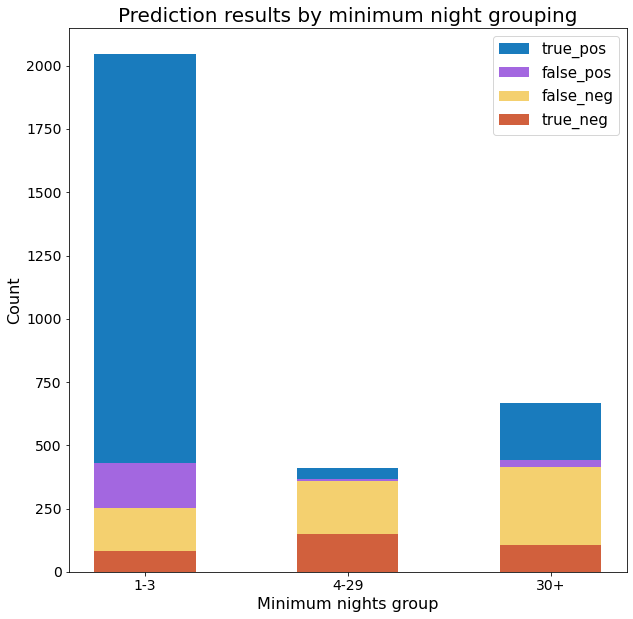

In [110]:
palette = {
    'true_pos': '#197BBD', 
    'false_pos': '#A367E0', 
    'false_neg': '#F4D06F', 
    'true_neg': '#D1603D'
}


# categorise minimum nights
def min_nights_categorise(nights: int) -> str:
    """
    Return a category for the given value of minimum nights.
    """
    if nights <=3:
        return "1-3" # most listings
    elif nights <= 29:
        return "4-29"
    else:
        return "30+"

results_evaluated['minimum_nights_cat'] = results_evaluated['minimum_nights'].apply(min_nights_categorise)

# group by minimum nights and possible result (true pos, true neg, etc)
results_by_min_nights = results_evaluated.groupby(['minimum_nights_cat', 'result'])['y'].count()
results_by_min_nights = results_by_min_nights.reset_index(drop = False).rename(columns = {'y': 'count'})

# plot the outcome
possible_results = ['true_neg', 'false_neg', 'false_pos', 'true_pos']
labels = ['1-3', '4-29', '30+']
fontcolor = 'black'
fig, ax = plt.subplots(figsize = (10,10))

# Create a stacked bar chart of prediction outcomes for each group of minimum nights
for i in range(4):
    # iterate through each possible result and filter to plot that result
    temp = results_by_min_nights[results_by_min_nights['result'] == possible_results[i]]
    if i==0:
        # first bar starts at 0
        bottom = [0] * len(temp)
    ax.bar(labels, temp['count'], width=0.5, bottom=bottom, label=possible_results[i], color = palette[possible_results[i]])
    # next bar starts at height of previous bar
    bottom = [x + y for x,y in zip(bottom, temp['count'])]

ax.set_xlabel('Minimum nights group', fontsize = 16, color = fontcolor)
ax.set_ylabel('Count', fontsize = 16, color = fontcolor)
ax.set_title('Prediction results by minimum night grouping', fontsize = 20, color = fontcolor)
ax.set_xticklabels(labels, fontsize = 14, color= fontcolor)

ax.legend()

plt.draw()

ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14, color = fontcolor)

handles, labels = ax.get_legend_handles_labels()
# reverse the order
ax.legend(handles[::-1], labels[::-1], fontsize = 15);

In this image it is much clearer; the proportion of listings predicted to not have reviews is much greater among listings with minimum nights greater than 3.

Finally, we investigate the impact of room type.

FixedFormatter should only be used together with FixedLocator


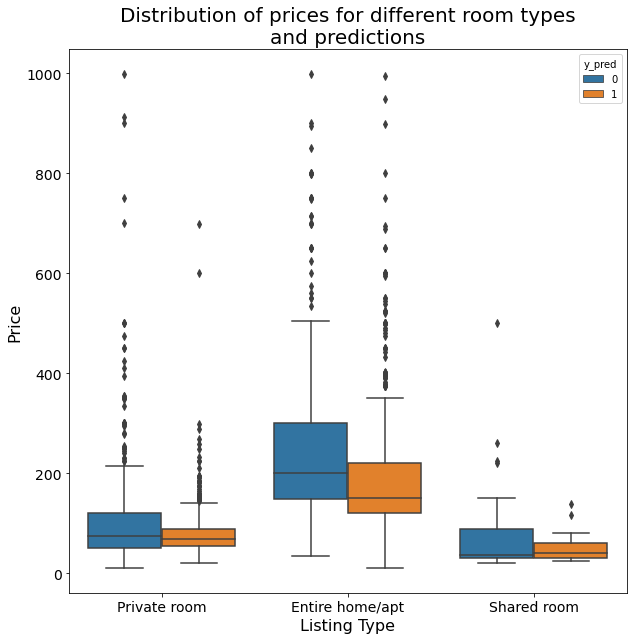

In [111]:
fontcolor = 'black'

fig, ax = plt.subplots(figsize = (10,10))
# plot distribution of price for different room types, color by prediction
sns.boxplot(data = results_evaluated[results_evaluated['price']<1000], x = 'room_type', y = 'price', hue = 'y_pred')
ax.set_xlabel('Listing Type', fontsize = 16, color = fontcolor)
ax.set_ylabel('Price', fontsize = 16, color = fontcolor)
ax.set_title("Distribution of prices for different room types\nand predictions", fontsize = 20, color = fontcolor)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 14, color= fontcolor)

plt.draw()

ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14, color = fontcolor);

The median price of "entire home/apt" listings is lower among listings predicted not to have reviews than among those predicted to have reviews. This does not appear to be the case for other room types. 

FixedFormatter should only be used together with FixedLocator


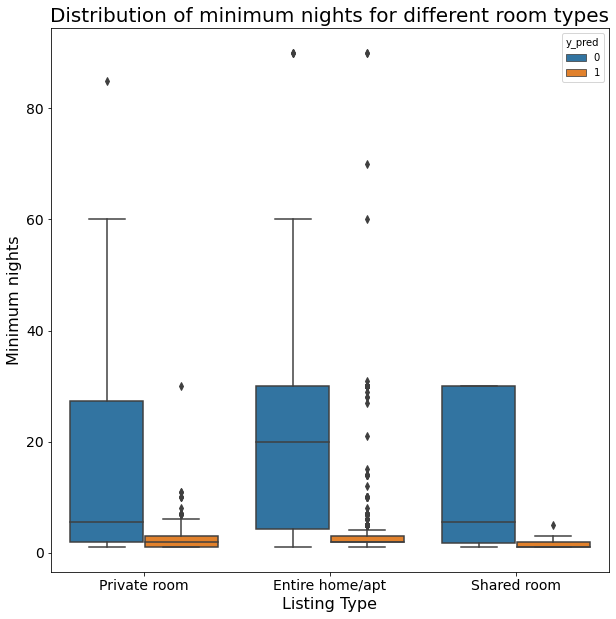

In [112]:
fig, ax = plt.subplots(figsize = (10,10))

# plot distribution of minimum nights by room type, color by prediciton.
sns.boxplot(data = results_evaluated[results_evaluated['minimum_nights']<100], 
            x = 'room_type', y = 'minimum_nights', hue = 'y_pred')

ax.set_xlabel('Listing Type', fontsize = 16, color = fontcolor)
ax.set_ylabel('Minimum nights', fontsize = 16, color = fontcolor)
ax.set_title("Distribution of minimum nights for different room types", fontsize = 20, color = fontcolor)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 14, color= fontcolor)

plt.draw()

ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14, color = fontcolor);

Among all room types, the median minimum nights among listings predicted to have reviews is much lower than that for listings predicted not to have reviews. The discrepancy is most pronounced among "entire home/apt" listings. Furthermore, the interquartile range of minimum nights values is far more narrow among listings predicted to have reviews than among listings predicted not to have reviews.

In [113]:
# group prediction results (true pos, true neg etc) by room type
results_by_room_type = results_evaluated.groupby(['room_type', 'result'])['y'].count()
results_by_room_type = results_by_room_type.reset_index(drop = False).rename(columns = {'y': 'count'})

# count how many of each room type
count_room_types = results_evaluated.groupby(['room_type'])['y'].count()
count_room_types = count_room_types.reset_index(drop = False).rename(columns = {'y': 'total'})

# merge the two table together to calculate proportion
results_by_room_type = results_by_room_type.merge(count_room_types, how = 'left', on = 'room_type')
results_by_room_type['proportion_of_room_type'] = results_by_room_type['count']/results_by_room_type['total']
results_by_room_type

room_type     result  count  total  proportion_of_room_type
0   Entire home/apt  false_neg    364   1627                 0.223725
1   Entire home/apt  false_pos    114   1627                 0.070068
2   Entire home/apt   true_neg    187   1627                 0.114935
3   Entire home/apt   true_pos    962   1627                 0.591272
4      Private room  false_neg    306   1415                 0.216254
5      Private room  false_pos     94   1415                 0.066431
6      Private room   true_neg    139   1415                 0.098233
7      Private room   true_pos    876   1415                 0.619081
8       Shared room  false_neg     20     83                 0.240964
9       Shared room  false_pos      6     83                 0.072289
10      Shared room   true_neg     12     83                 0.144578
11      Shared room   true_pos     45     83                 0.542169

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


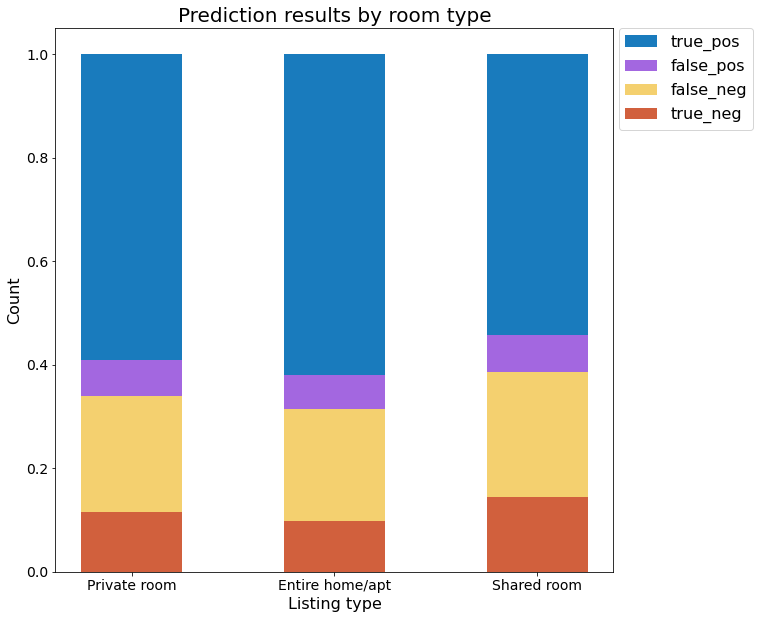

In [114]:
# plot the combined dataframe

possible_results = ['true_neg', 'false_neg', 'false_pos', 'true_pos']
labels = ['Private room', 'Entire home/apt', 'Shared room']

fig, ax = plt.subplots(figsize = (10,10))

for i in range(4):
    # filter each possible result
    temp = results_by_room_type[results_by_room_type['result'] == possible_results[i]]
    if i==0:
        # first bar has base at 0
        bottom = [0] * len(temp)
    # create a stacked bar chart
    ax.bar(labels, temp['proportion_of_room_type'], width=0.5, 
           bottom=bottom, label=possible_results[i], color = palette[possible_results[i]])
    # shift base to height of this bar
    bottom = [x + y for x,y in zip(bottom, temp['proportion_of_room_type'])]

ax.set_ylabel('Count', fontsize = 16, color = fontcolor)
ax.set_title('Prediction results by room type', fontsize = 20, color = fontcolor)
ax.set_xlabel('Listing type', fontsize = 16, color = fontcolor)

plt.draw()

ax.set_xticklabels(ax.get_xticklabels(), fontsize = 14, color = fontcolor)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14, color = fontcolor)

# reverse order of legend
plt.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize = 16, bbox_to_anchor=(1.01, 1),borderaxespad=0);

It does not appear that room type itself has a major impact on the model's prediction, but other variables such as price and minimum nights have varying effects on the prediction depending on the room type.

The conclusions drawn from this investigation are presented in Task 3, supplied as `ST20166622 CIS5026 WRIT1_3.pdf`.

# References

Airbnb (2021) What factors determine how my listing appears in search results?  [online] Available at [https://www.airbnb.co.uk/help/article/39/what-factors-determine-how-my-listing-appears-in-search-results](https://www.airbnb.co.uk/help/article/39/what-factors-determine-how-my-listing-appears-in-search-results)

Géron, A. (2019). *Hands-On Machine Learning with SciKit-Lean, Keras and TensorFlow*. CA: O’Reilly Media Inc. Available from [https://learning.oreilly.com/library/view/hands-on-machine-learning/](https://learning.oreilly.com/library/view/hands-on-machine-learning/) [Accessed 20/03/2020]

Hale, J. (2019). Scale, Standardize, or Normalize with Scikit-Learn. *Towards Data Science* [online] Available at [https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02) [Accessed 08/03/2020].

Jhaver,S. Karpfen,Y. and Antin, J. (2018) Algorithmic Anxiety and Coping Strategies of Airbnb Hosts. Proceedings of the 2018 CHI Conference on Human Factors in Computing Systems. Association for Computing Machinery, New York, Paper 421, 1–12

Kaggle (2019) New York City Airbnb Open Data [online] Available at [https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data).

Lundberg, S. (2018) Interpretable Machine Learning with XGBoost. Towards Data Science [online] Available at https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27 

Mishra, S. (2017) ‘Handling Imbalanced Data: SMOTE vs. Random Undersampling’. International Research Journal of Engineering and Technology (IRJET) 4 (8) pp 317-320

Morde, V. and Setty, V. (2019) ‘XGBoost Algorithm: Long May She Reign!’ Towards Data Science [online] Available at https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d 

New York State Senate (1929) Article 1: Introductory Provisions; Definitions. *New York State Multiple Dwelling Law* [online] Available at [https://www1.nyc.gov/assets/buildings/pdf/MultipleDwellingLaw.pdf](https://www1.nyc.gov/assets/buildings/pdf/MultipleDwellingLaw.pdf).

Reinhold, S. and Dolnicar, S. (2018) ‘Airbnb’s Business Model’. In Dolnicar, S. Peer-to-peer Accommodation Networks. Oxford: Goodfellow Publishers. pp. 27-38